In this Notebook, we prepare the Proximus data into a usable mobility matrix at the level of postal codes, municipalities, arrondissements and provinces.

- Question: how should we interpret the foreigners that go abroad? The current matrix for December 21st says that there are roughly 200k people that come from abroad and go abroad. What does that mean?
- Question: how should we handle the -1 values? Is there a clever way to go about?
    - Add 0
    - Add some value between 0 and 30 (such as 10)
    - Add a random value between 0 and 30 every time
    - Extrapolate the actual value from the values at all previous days: if for some days the value goes above 30, the average value is expected to be close to 30 as well, whilst the opposite is true if the value is _always_ at -1.
- Question: how should we handle multiple visits per day (i.e. people coming from place A, visiting place B and C, and returning to place A)
- Question: the raw data is not a square matrix, so some postal codes are missing. This is not an issue after aggregation into municipalities
- Problem: Herstappe (PC 3717, NIS 73028) is not in the data (only 88 inhabitants). How to handle this?
- Question: _our_ list of postal codes is 1147 PCs long. The Internet claims there are 1169 PCs in Belgium (including special PCs for e.g. military bases). We stick with the 1147?
- Problem: There is no data for a number of small PC regions, such as Herstappe (PC 3717)
- Question: what is considered a *visit*? In corona times, people are still staying connected, but perhaps not leaving their house. How is this counted? Something is definitely visible, because the overall number of visits clearly goes down, especially in the first wave.
- Problem: there is no data for who goes abroad in the first few weeks (so also no baseline mobility to be calculated there).

# Load packages

In [52]:
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime
# sys.path.insert(0, "../tools")
from covid19model.data.mobility import * # contains all necessary functions
from covid19model.visualization.utils import moving_avg

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

**Legend**

- _mllp_postalcode_ : Postalcode (PC) of the most likely living place (MLLP) of the Proximus client
- _postalcode_ : Visited postalcode (when device had consecutive transactions on the same cell in the PC for at least 15 min)
- _imsisinpostalcode_ : Number of users having that PC as MLLP 
- _habitants_ : Reference data for that PC 
- _nrofimsi_ : Number of users (proximus only) that were in the PC, -1 if < 30 (we can only report about groups >= 30, for GDPR reasons)
- _visitors_ : extrapolated value of the users, -1 if < 30 (we can only report about groups >= 30, for GDPR reasons)
- _est_staytime_ : total time spent (in seconds) by all users from *mllp_postalcode* in *postalcode*
- _total_est_staytime_ : total registered time spend by all users from *mllp_postalcode* on the network 
- _est_staytime_perc_ : _est_staytime_ / _total_est_staytime_ * 100%: This almost provides the mobility matrix that we need, but not quite.

We are mainly interested in _nrofimsi_ , because we want to know how many people from PC _x_ travel to PC _y_. Perhaps it is interesting to, in a next stage, weigh this with respect to the length of stay.

# Load and clean data

NOTE: these private data are _not_ shared on GitHub (.gitignore). Make sure you downloaded the latest version from the S-drive and manually updated the relevant directory.

In [2]:
# Example: data for a single date. Note that the function is made to load several dates at once in a dict.

data_location = "../../data/raw/mobility/proximus/"
date='20201221'
mmprox = load_mobility_proximus(date, data_location)

# Nonessential help functions
def print_date(today):
    print('==========')
    print(today[:4], today[4:6], today[6:])
    print('==========')
    
def visualise_matrix(mmprox, cmap='Wistia', interpolation=None):
    # Note the log scale
    offset=1.01
    raw_matrix=np.log(np.array(mmprox.values, dtype=float)+offset)
    plt.imshow(raw_matrix, cmap=cmap, interpolation=interpolation)
    plt.show()
    
print_date(date)
mmprox[date]

Loaded dataframe for date 20201221.
2020 12 21


1000   1020   1030   1040   1050  1060  1070  1080  1081  \
mllp_postalcode                                                              
1000             12934    278    485    695   1069  1458  1264  1493   128   
1020              1063  12727    753    362    496   259   714   728   155   
1030              2398    959  25789   2417   1414   536   699   519   115   
1040              1597    201   1883  18738   3565   427   395   255    68   
1050              2654    238    719   2998  29072  1909   745   326    86   
...                ...    ...    ...    ...    ...   ...   ...   ...   ...   
9988                 0      0      0      0      0     0    -1     0     0   
9990                -1     -1     -1     -1     -1    -1    -1     0     0   
9991                -1      0      0      0     -1    -1     0     0     0   
9992                 0      0      0      0     -1     0     0     0     0   
Foreigner         7745   2134   5270   6372   8554  4416  5525  3327   732   

                 1082  ...  9970  9971  9980  9981  9982  9988  9990  9991  \
mllp_postalcode        ...                                                   
1000              107  ...     0     0     0     0     0     0     0     0   
1020              284  ...    -1    -1     0     0     0     0     0    -1   
1030              146  ...     0     0     0     0     0     0    -1    -1   
1040               93  ...     0     0     0     0     0     0    -1    -1   
1050              100  ...     0    -1     0     0     0     0    -1     0   
...               ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
9988                0  ...    86    -1    -1    -1   106   760    45    74   
9990               -1  ...    -1    -1    34    -1    -1    -1  4764   817   
9991                0  ...    30    40    47    -1    -1    -1   812  2623   
9992                0  ...    -1    -1    -1    -1    -1    -1    87    -1   
Foreigner         864  ...    55    61    49    -1    71   172   516   254   

                 9992  ABROAD  
mllp_postalcode                
1000                0    1080  
1020                0     406  
1030                0    1432  
1040                0    2527  
1050                0    4000  
...               ...     ...  
9988               -1      71  
9990               56     145  
9991               -1      63  
9992              254      45  
Foreigner         126  210199  

[1126 rows x 1132 columns]

In [3]:
# Change the -1 values for visits to values between 1 and 30

mmprox_GDPR = GDPR_replace(mmprox[date])
print_date(date)
mmprox_GDPR

2020 12 21


1000   1020   1030   1040   1050  1060  1070  1080 1081  \
mllp_postalcode                                                             
1000             12934    278    485    695   1069  1458  1264  1493  128   
1020              1063  12727    753    362    496   259   714   728  155   
1030              2398    959  25789   2417   1414   536   699   519  115   
1040              1597    201   1883  18738   3565   427   395   255   68   
1050              2654    238    719   2998  29072  1909   745   326   86   
...                ...    ...    ...    ...    ...   ...   ...   ...  ...   
9988                 0      0      0      0      0     0     7     0    0   
9990                 4      4      5      3      6     1     1     0    0   
9991                 3      0      0      0      8     4     0     0    0   
9992                 0      0      0      0      2     0     0     0    0   
Foreigner         7745   2134   5270   6372   8554  4416  5525  3327  732   

                1082  ... 9970 9971 9980 9981 9982 9988  9990  9991 9992  \
mllp_postalcode       ...                                                  
1000             107  ...    0    0    0    0    0    0     0     0    0   
1020             284  ...    7   13    0    0    0    0     0    18    0   
1030             146  ...    0    0    0    0    0    0    18     2    0   
1040              93  ...    0    0    0    0    0    0     2     4    0   
1050             100  ...    0   14    0    0    0    0     4     0    0   
...              ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
9988               0  ...   86    4   11    2  106  760    45    74    1   
9990               4  ...    9    3   34    6    9    7  4764   817   56   
9991               0  ...   30   40   47    6   14    3   812  2623    7   
9992               0  ...    2   12    4    3    5    5    87     3  254   
Foreigner        864  ...   55   61   49    5   71  172   516   254  126   

                 ABROAD  
mllp_postalcode          
1000               1080  
1020                406  
1030               1432  
1040               2527  
1050               4000  
...                 ...  
9988                 71  
9990                145  
9991                 63  
9992                 45  
Foreigner        210199  

[1126 rows x 1132 columns]

In [4]:
# Add missing postal codes in rows and columns

mmprox_complete = fill_missing_pc(mmprox_GDPR)
print_date(date)
mmprox_complete

2020 12 21


1000   1020   1030   1040   1050  1060  1070  1080 1081  \
mllp_postalcode                                                             
1000             12934    278    485    695   1069  1458  1264  1493  128   
1020              1063  12727    753    362    496   259   714   728  155   
1030              2398    959  25789   2417   1414   536   699   519  115   
1040              1597    201   1883  18738   3565   427   395   255   68   
1050              2654    238    719   2998  29072  1909   745   326   86   
...                ...    ...    ...    ...    ...   ...   ...   ...  ...   
7543                 0      0      0      0      0     0     0     0    0   
7783                 0      0      0      0      0     0     0     0    0   
8572                 0      0      0      0      0     0     0     0    0   
8952                 0      0      0      0      0     0     0     0    0   
9403                 0      0      0      0      0     0     0     0    0   

                1082  ... 3831 5572 5589 6986 7504 7533 7543 7783 8952 9403  
mllp_postalcode       ...                                                    
1000             107  ...    0    0    0    0    0    0    0    0    0    0  
1020             284  ...    0    0    0    0    0    0    0    0    0    0  
1030             146  ...    0    0    0    0    0    0    0    0    0    0  
1040              93  ...    0    0    0    0    0    0    0    0    0    0  
1050             100  ...    0    0    0    0    0    0    0    0    0    0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
7543               0  ...    0    0    0    0    0    0    0    0    0    0  
7783               0  ...    0    0    0    0    0    0    0    0    0    0  
8572               0  ...    0    0    0    0    0    0    0    0    0    0  
8952               0  ...    0    0    0    0    0    0    0    0    0    0  
9403               0  ...    0    0    0    0    0    0    0    0    0    0  

[1148 rows x 1148 columns]

# Spatial aggregation

In [5]:
# Municipality level

agg='mun'
mmprox_mun = mm_aggregate(mmprox_complete, agg=agg)
print_date(date)
mmprox_mun

2020 12 21


11001   11002  11004  11005  11007  11008  11009  11013  \
mllp_postalcode                                                            
11001             4604    1692      3    441      7      3      3    168   
11002             1085  184517    429    360   1539   2388    464   2584   
11004               36     831   4549      7    123     12     20    151   
11005              465    1040     14   5271      3      5      3     79   
11007                6    1533     99      9   2525      1      2     47   
...                ...     ...    ...    ...    ...    ...    ...    ...   
93022                0      17      0      0      0      0      0      0   
93056                0      16      0      0      0      2      8      0   
93088                0      19      0      0      0      0      0      0   
93090                0       9      0      0      0      0      0      0   
Foreigner          359   31851    234    410    183    979   1265    567   

                 11016  11018  ...  92141  92142  93010  93014  93018  93022  \
mllp_postalcode                ...                                             
11001               21    101  ...      0      5      1      0      0      0   
11002               76    615  ...     13     49     12     22      0     31   
11004                5     11  ...      4      8      0      0      0      0   
11005                3     67  ...      0     16      4      0      0      0   
11007                3      1  ...      0      0      0      2      0      0   
...                ...    ...  ...    ...    ...    ...    ...    ...    ...   
93022                0      0  ...     42     39     11     49     35   4462   
93056                0      0  ...      9     15    100    636    362    358   
93088                0      0  ...     17     28    223    120      4    637   
93090                0      7  ...      3     18      3    845    125     61   
Foreigner         1053    228  ...    364    865     64    975     94    240   

                 93056  93088  93090  ABROAD  
mllp_postalcode                               
11001                0      0      0      66  
11002                5     45     20    3148  
11004                0      0      0      43  
11005                0      0      0      74  
11007                2      0      0      55  
...                ...    ...    ...     ...  
93022              364    532     14      63  
93056             3795    307    177     190  
93088              562   8882      4     176  
93090              322     49   2890     233  
Foreigner          464    311    185  210199  

[582 rows x 582 columns]

<IPython.core.display.Javascript object>


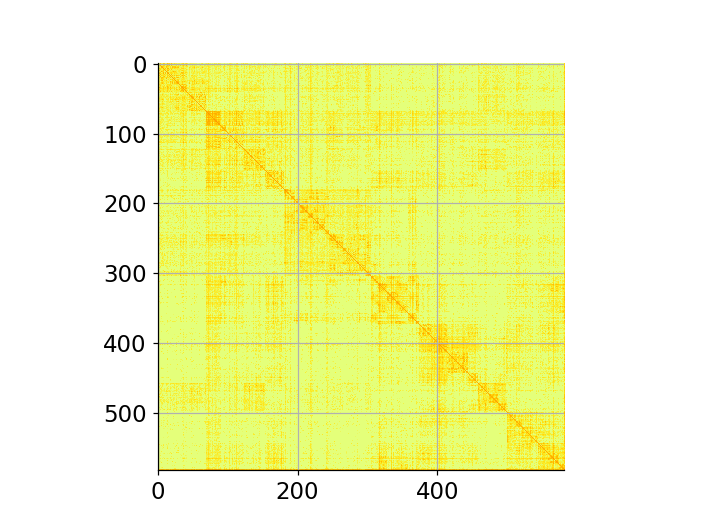

In [6]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_mun)

In [7]:
# Arrondissement level

agg='arr'
mmprox_arr = mm_aggregate(mmprox_complete, agg=agg)
mmprox_arr

11000   12000   13000   21000   23000   24000   25000  \
mllp_postalcode                                                           
11000            484919   15117   11719    4135    7297    5579    1810   
12000             19430  156002    6866    2631    9054    8801     998   
13000             13750    6403  208094    1602    2860    6601     678   
21000              4148    2116    1428  578204   56528    6081   14347   
23000              8256    9167    2543   76497  377460   14763   16572   
24000              7187    9420    6843    9016   17441  275774    6599   
25000              1906     765     629   23702   18128    7183  307113   
31000              1947     546     768    1180    1870    1079     566   
32000               337      98     137     149     290      91      40   
33000               574     153     213     371     713     363     139   
34000              1808     613     959    1099    2004     774     666   
35000              1020     305     353     667    1225     543     297   
36000               788     260     264     452     738     419     149   
37000               827     216     299     365     694     411     281   
38000               661     116     214     366     490     245     289   
41000              2340     883     740    5515   17011    1690    1319   
42000              2641    3169     927    1367    5587    1079     659   
43000              1068     238     215     276     740     205     124   
44000              4895    1505    1712    3020    5541    2258    1231   
45000               965     283     382     936    1769     528     318   
46000             10524    2620     938     867    1842    1010     507   
51000               425     209     207    3644    6558     469    3537   
52000               772     319     246    4018    3986     870    9230   
53000               500     196     183    3285    2794     563    3110   
55000               271      62      88    2663    2113     363    7191   
56000               135      69      32    1246     875     151    1658   
57000               780     201     246    2775    2428     467    1721   
58000               222      53      61    1719    1223     337    2124   
61000               151     104     129    1363     689     671    1753   
62000              1103     346     907    4238    2416    2139    3674   
63000               755     242     350    1969    1077    1060    1648   
64000               224      82     135    1350     976    1359    2913   
71000              3527    1325    6729    1762    2759   12876     946   
72000              2075     689    3517     809    1124    2301     242   
73000              1531     640    1183     885    1182    2795     678   
81000                41       5       4     259     186      77     218   
82000               212      40     100     437     209     173     324   
83000               352      70     163     801     533     403     896   
84000               283     148      98     885     449     241     978   
85000               122      31      20     585     232     117     421   
91000               484     133     183    1918    1621     504    2750   
92000               938     207     247    3775    2922    1320   12032   
93000               195      26      34     688     670     153    1068   
Foreigner         51821    7361   23387   72025   26565   12961   15189   

                  31000  32000  33000  ...  73000  81000  82000  83000  84000  \
mllp_postalcode                        ...                                      
11000              3092    315    756  ...   1677    169    934   1274   1075   
12000               905     99    356  ...    709    161    366    608    400   
13000              1292    144    301  ...   1323    115    461    667    431   
21000              2122    186    386  ...    919    633    956   1397   1510   
23000              3064    268    448  ...   1115    361    922   1514   1468   


<IPython.core.display.Javascript object>


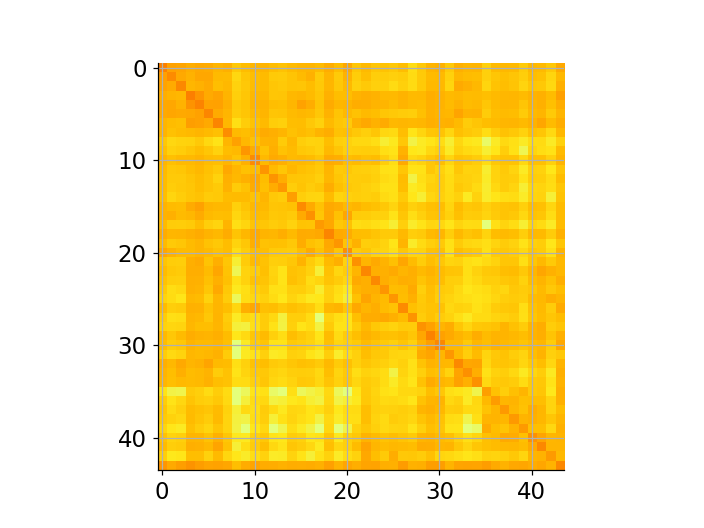

In [8]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_arr)

In [9]:
# Province level

agg='prov'
mmprox_prov = mm_aggregate(mmprox_complete, agg=agg)
print_date(date)
mmprox_prov

2020 12 21


10000   20001   20002   21000   30000   40000   50000  \
mllp_postalcode                                                           
10000            922300   40192    3486    8368   18318   29704    6112   
20001             43416  685438   23171   85513   18268   36317   19307   
20002              3300   25311  307113   23702    4244    2901   22752   
21000              7692   62609   14347  578204    7469    7408   14006   
30000             13476   11949    2427    4649  669867   40706   20580   
40000             36045   39260    4158   11981   45573  837253   16597   
50000              5277   23197   28571   19350   25639   15972  999828   
60000              4528   10387    9988    8920    6309    3732   13444   
70000             21216   23037    1866    3456    6281    6514    2520   
80000              1689    2620    2837    2967    2120    1138    5581   
90000              2447    7190   15850    6381    3753    2419   38970   
Foreigner         82569   39526   15189   72025   45004   43759   70127   

                  60000   70000   80000   90000  ABROAD  
mllp_postalcode                                          
10000              9872   20258    7222    4764   11231  
20001             13771   21721    7425    8721    6468  
20002             10619    1638    5981   14132    4288  
21000              8664    3185    5397    6330   20656  
30000              4620    4672    4944    4045    6166  
40000              8100    6841    7401    5947    7558  
50000             13092    1936    8093   30129   15692  
60000            871012   12754   17360   19850   12163  
70000             15749  438519    2791    2137    7412  
80000             15407     855  192296   14824   11972  
90000             19908    1361   18859  368428    4864  
Foreigner         53792   39081   54537   17379  210199

<IPython.core.display.Javascript object>


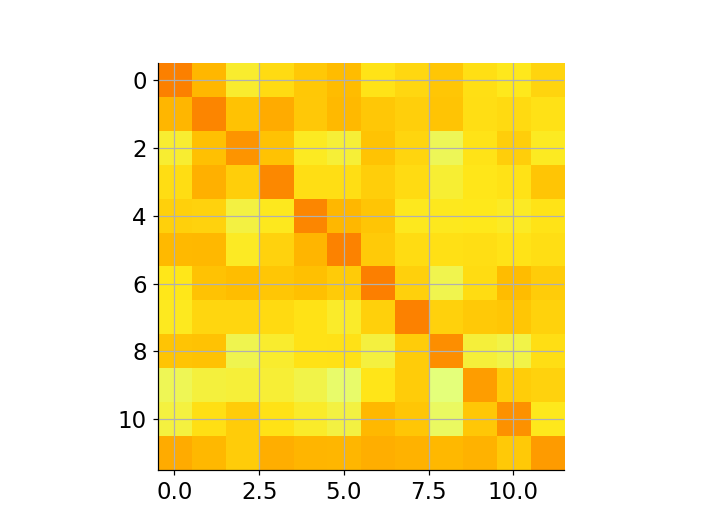

In [10]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_prov)

# All-in-one solution

In [11]:
agg = 'arr'
mmprox_clean = complete_data_clean(mmprox[date], agg=agg)
mmprox_clean

11000   12000   13000   21000   23000   24000   25000  \
mllp_postalcode                                                           
11000            485351   15129   11502    4191    7398    5699    1916   
12000             19377  155813    6811    2749    9189    8814    1114   
13000             13722    6296  208229    1372    2823    6686     619   
21000              3966    2114    1559  578192   57085    6125   14193   
23000              8096    8995    2561   76514  376926   14465   16843   
24000              6863    9361    7170    8769   17334  275905    6619   
25000              1695     849     618   23913   17939    7227  307099   
31000              1951     596     847    1200    1921    1144     566   
32000               265      75     113     163     389      83      57   
33000               452     151     215     355     734     386     169   
34000              1990     566     911    1137    2030     848     762   
35000              1012     351     351     707    1083     534     286   
36000               717     218     273     444     805     338     147   
37000               820     247     258     398     767     542     224   
38000               451      92     170     401     572     289     303   
41000              2452     968     801    5545   17129    1620    1341   
42000              2641    3158     796    1351    5644    1447     587   
43000              1023     343     219     378     711     213      79   
44000              4759    1434    1759    2924    5233    2167    1187   
45000               899     261     428     937    1805     501     266   
46000             10412    2628    1240     855    1808    1084     448   
51000               372     210     197    3374    6640     465    3413   
52000               753     314     284    4107    4243     775    9328   
53000               563     163     178    3187    2577     628    3178   
55000               256      87      92    2567    2179     412    7248   
56000               124      66      31    1307     849     201    1517   
57000               733     186     254    2637    2542     481    1548   
58000               204      52      70    1536    1335     283    2106   
61000               157      56     109    1422     685     563    1733   
62000              1208     371     858    4294    2545    2216    3806   
63000               844     161     457    1775    1102    1044    1635   
64000               231     101     172    1454     947    1340    2922   
71000              3480    1270    6720    1651    2460   13014     811   
72000              2080     754    3444     764    1121    2424     220   
73000              1602     633    1285     902    1240    2902     526   
81000                41       3       2     274     151      65     214   
82000               238      45      44     306     181     196     334   
83000               433      46     112     805     519     425     893   
84000               253     118      91     902     491     300     904   
85000               120      54      32     693     256      62     388   
91000               434     144     202    1823    1346     517    2840   
92000               989     273     239    4174    3141    1252   12141   
93000               212      21      30     738     575     140    1101   
Foreigner         51821    7361   23387   72025   26544   12912   15200   

                  31000  32000  33000  ...  73000  81000  82000  83000  84000  \
mllp_postalcode                        ...                                      
11000              2972    258    703  ...   1534    228   1041   1354   1132   
12000              1006     87    296  ...    655    119    392    631    425   
13000              1302    165    224  ...   1134    142    470    618    466   
21000              2085    169    436  ...    807    623   1023   1432   1441   
23000              3051    232    525  ...   1006    394    815   1344   1384   


# Visualisation

In [12]:
# Visualisation in geopandas
import geopandas as gp

shp_dir = "../../data/raw/GIS/shapefiles/BE/"

# Load different geographical aggregations
country = gp.read_file(shp_dir + "AD_6_Country.shp")
regions = gp.read_file(shp_dir + "AD_5_Region.shp")
provinces = gp.read_file(shp_dir + "AD_4_Province.shp")
arrondissements = gp.read_file(shp_dir + "AD_3_District.shp")
municipalities = gp.read_file(shp_dir + "AD_2_Municipality.shp")

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Create circle denoting foreigners
import shapely.affinity
from shapely.geometry import Point
circle = Point(570000, 600000).buffer(1)  # type(circle)=polygon
radius = 1.3e4
ellipse = shapely.affinity.scale(circle, radius, radius)  # type(ellipse)=polygon

# Add additional column to geopandas dataframes for foreigners, depicted by circle
foreign_mun = pd.DataFrame([[np.nan, np.nan, np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=municipalities.columns)
municipalities = municipalities.append(foreign_mun, ignore_index=True)

foreign_arr = pd.DataFrame([[np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=arrondissements.columns)
arrondissements = arrondissements.append(foreign_arr, ignore_index=True)

foreign_prov = pd.DataFrame([[np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=provinces.columns)
provinces = provinces.append(foreign_prov, ignore_index=True)

## Municipality level

In [17]:
# Add columns with 'traffic to' values
to_NIS = ['44021', '21004', '11002'] # Ghent, Brussels, Antwerp
# to_NIS = ['93014']

# Prepare empty columns
for nis in to_NIS:
    municipalities['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in municipalities['NISCode'].values:
    for nis_to in to_NIS:
        municipalities.loc[municipalities['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_mun.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


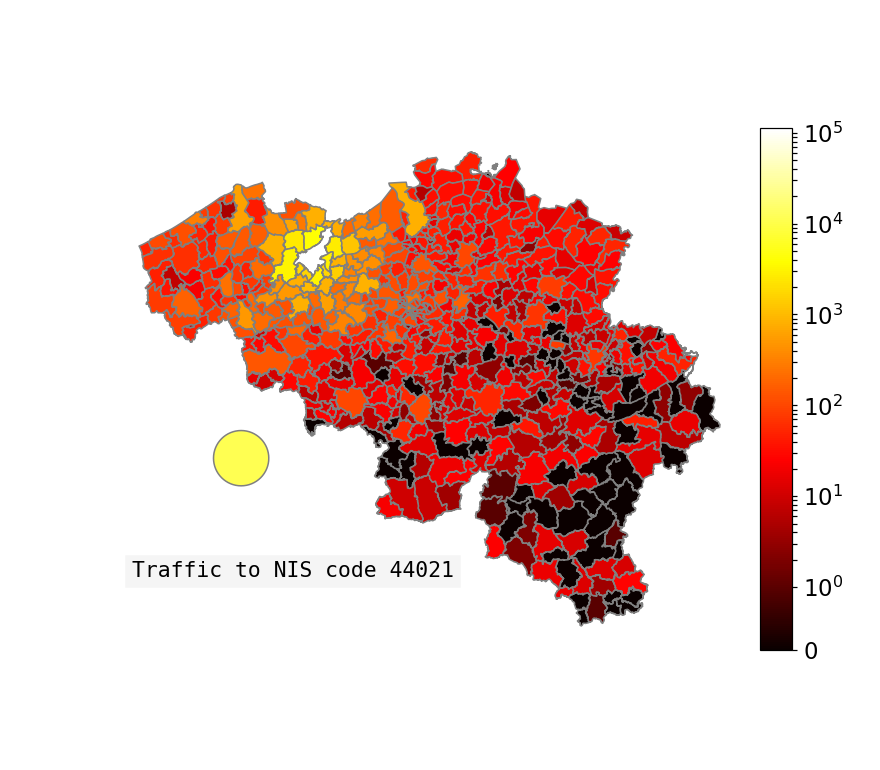

<IPython.core.display.Javascript object>


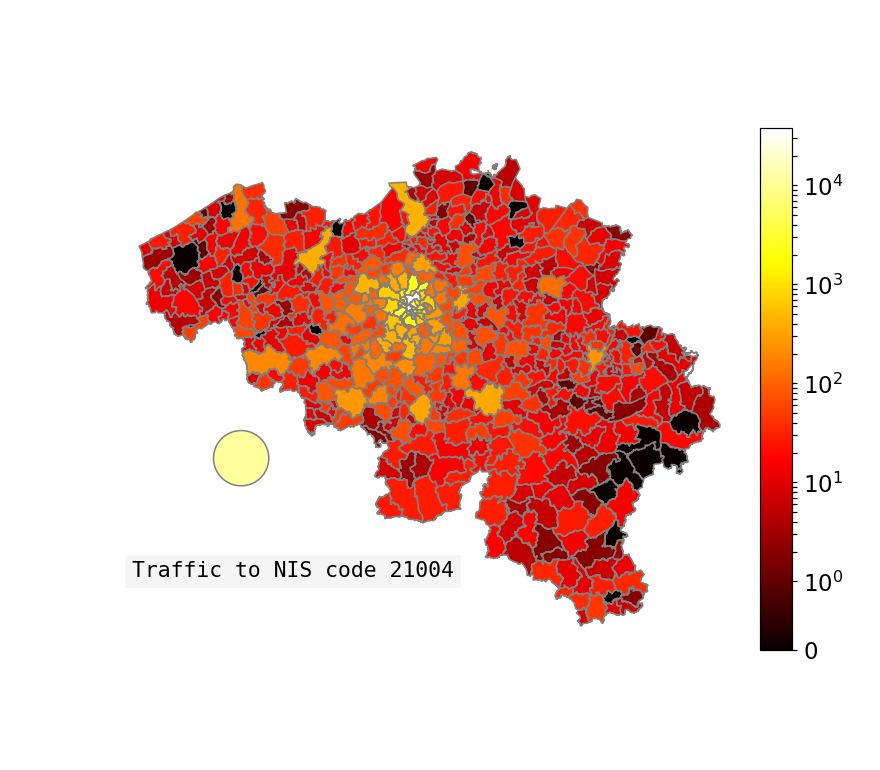

<IPython.core.display.Javascript object>


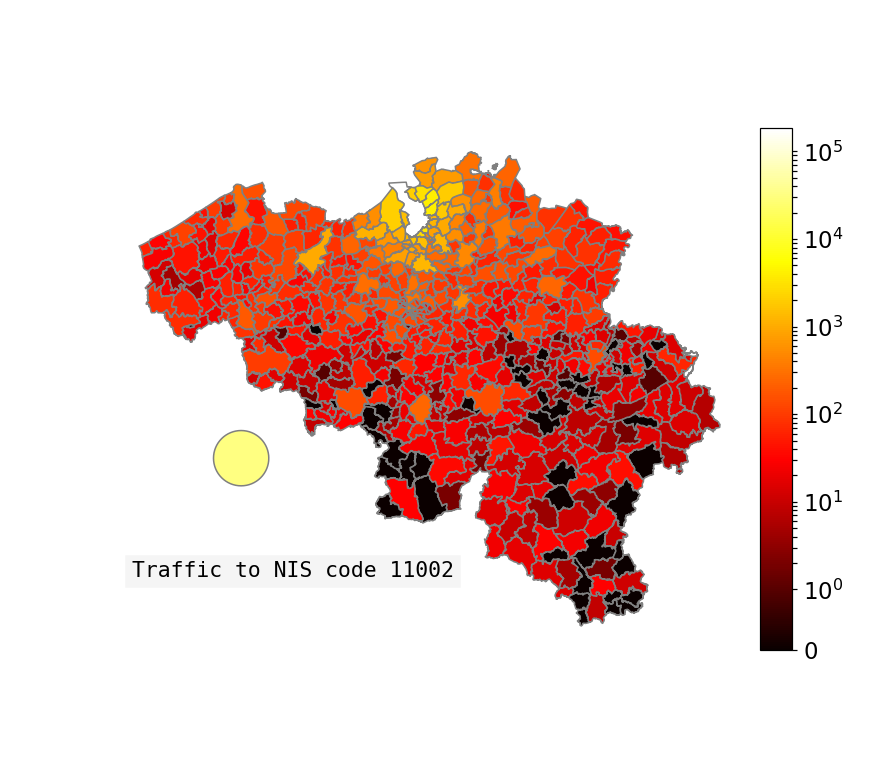

In [18]:
# Plot connections

from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
from matplotlib import colors

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(municipalities['Traffic to ' + nis])
    fig = municipalities.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
#     plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/municipalities/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

## Arrondissement level

In [19]:
# visualise in geopandas

# Add columns with 'traffic to' values
to_NIS = ['44000', '21000', '11000'] # Ghent, Brussels, Antwerp

# Prepare empty columns
for nis in to_NIS:
    arrondissements['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in arrondissements['NISCode'].values:
    for nis_to in to_NIS:
        arrondissements.loc[arrondissements['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_arr.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


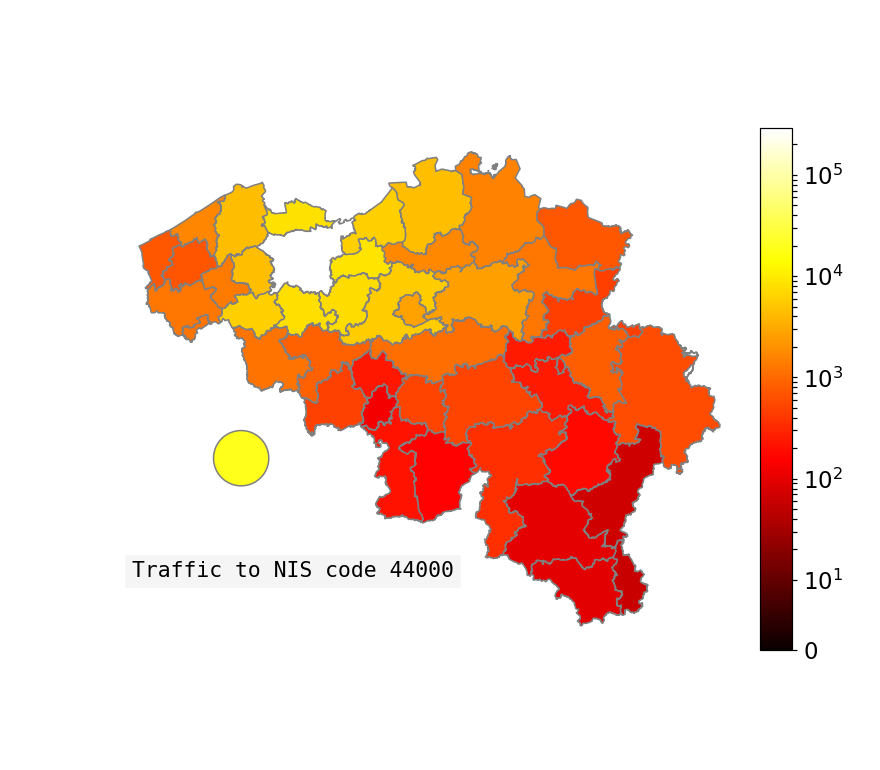

<IPython.core.display.Javascript object>


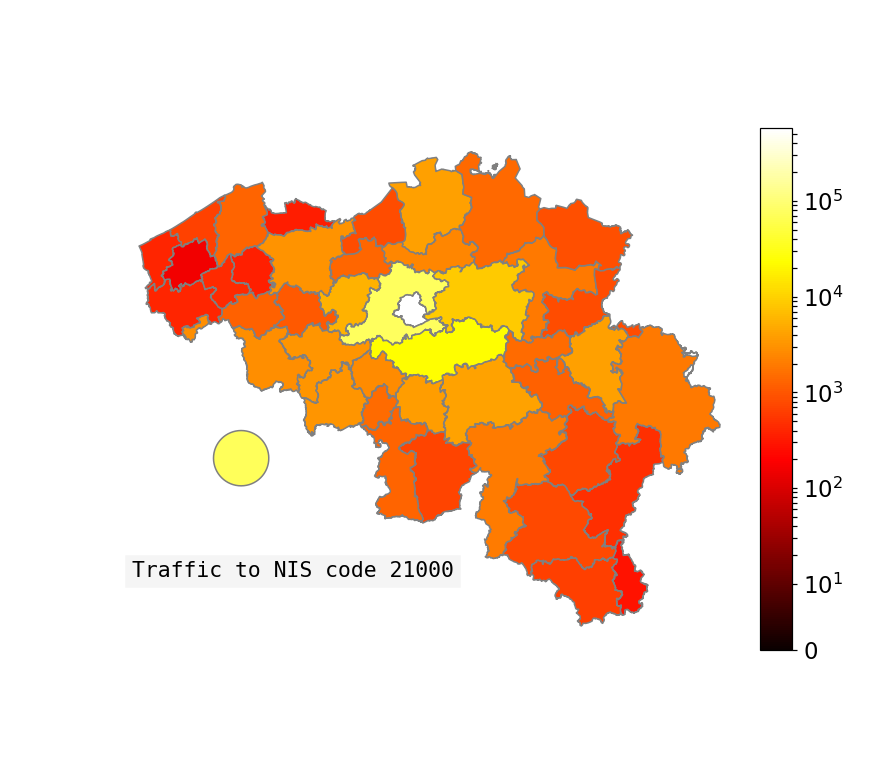

<IPython.core.display.Javascript object>


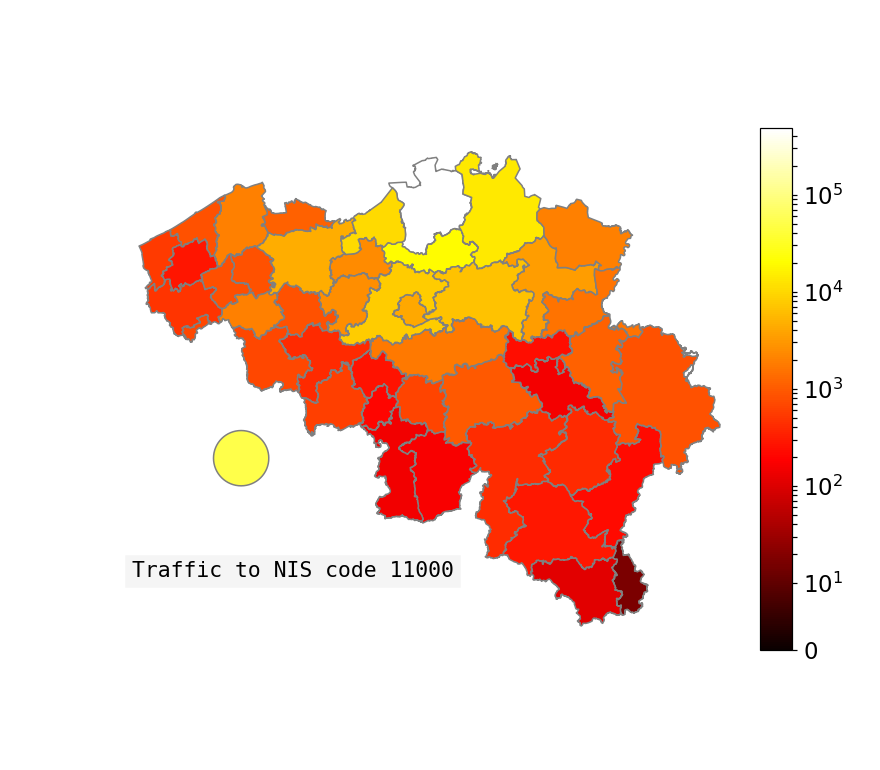

In [20]:
# Plot connections

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(arrondissements['Traffic to ' + nis])
    fig = arrondissements.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=10, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    # plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/arrondissements/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

## Province level

In [21]:
# visualise in geopandas

# Add columns with 'traffic to' values
to_NIS = ['40000', '21000', '10000'] # Ghent, Brussels, Antwerp

# Prepare empty columns
for nis in to_NIS:
    provinces['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in provinces['NISCode'].values:
    for nis_to in to_NIS:
        provinces.loc[provinces['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_prov.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


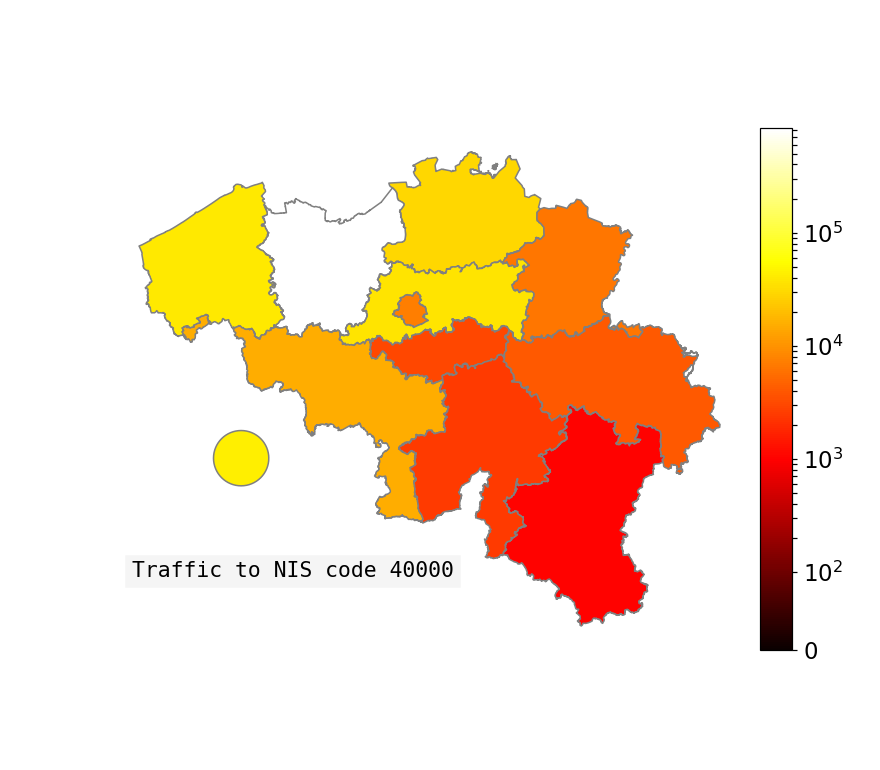

<IPython.core.display.Javascript object>


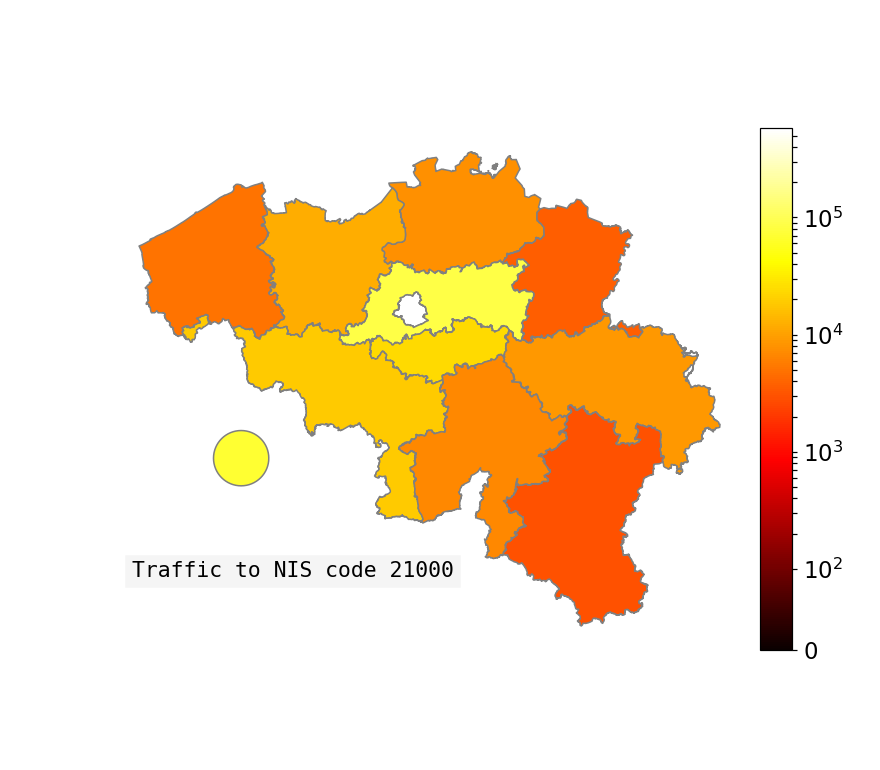

<IPython.core.display.Javascript object>


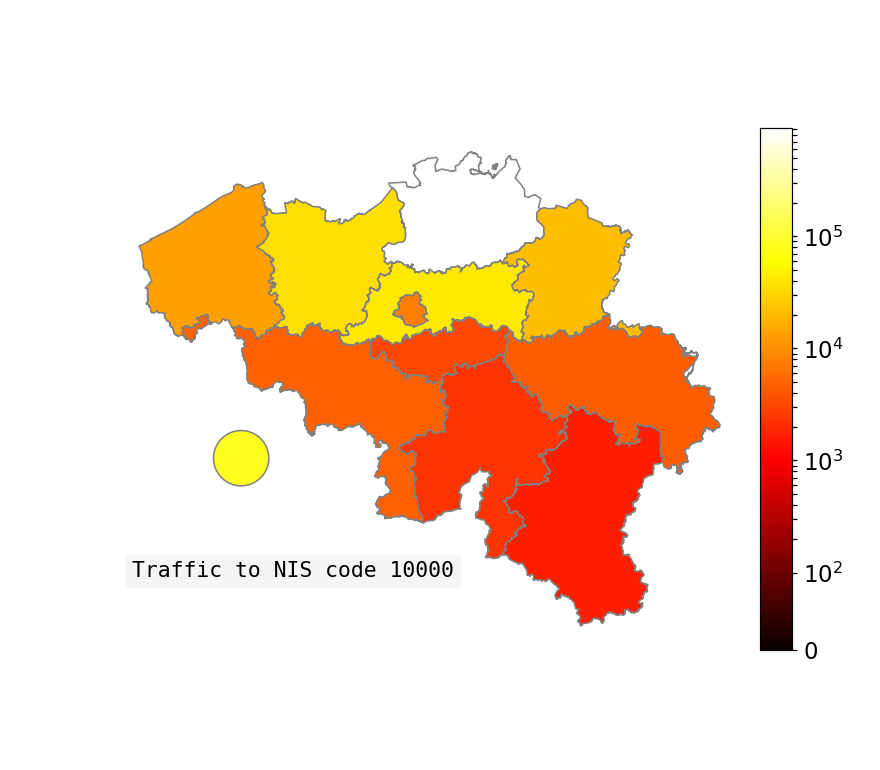

In [22]:
# Plot connections

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(provinces['Traffic to ' + nis])
    fig = provinces.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=100, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    # plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/provinces/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

# Temporal aggregation

In [26]:
# TAKES A WHILE TO LOAD

# Select dates of the week the mobility will be averaged over
week_nr = 51
dates=make_date_list(week_nr) # [YYYYMMDD, ...]

# Load data for all these dates
location = '../../data/raw/mobility/proximus/'
mmprox = load_mobility_proximus(dates, data_location)

# Clean data for all dates
agg='mun'
for date in mmprox:
    mmprox[date] = complete_data_clean(mmprox[date], agg=agg)

... proceeding with 6 dates.
Loaded dataframe for date 20201220.    


In [27]:
# Take average of all mobility matrices in the mmprox dictionary
mmprox_avg = average_mobility(mmprox)
mmprox_avg

11001          11002        11004        11005  \
mllp_postalcode                                                         
11001            4640.500000    1705.833333    11.833333   436.833333   
11002            1067.500000  191359.333333   540.833333   401.500000   
11004              35.000000     954.500000  4600.833333     9.666667   
11005             492.666667    1052.333333     7.500000  5269.000000   
11007               7.333333    1609.666667   116.333333     8.833333   
...                      ...            ...          ...          ...   
93022               0.000000      10.000000     0.000000     0.000000   
93056               0.000000       7.333333     0.000000     0.333333   
93088               2.833333      35.333333     0.166667     0.833333   
93090               0.000000      12.166667     0.000000     0.000000   
Foreigner         398.666667   35313.000000   242.166667   471.000000   

                       11007        11008        11009        11013  \
mllp_postalcode                                                       
11001               5.500000     7.500000     2.666667   176.666667   
11002            1528.666667  2677.666667   562.500000  2722.000000   
11004             155.000000     7.833333     7.666667   176.166667   
11005               5.666667     3.000000     3.166667    78.500000   
11007            2550.666667    12.666667     5.000000    35.833333   
...                      ...          ...          ...          ...   
93022               0.000000     0.166667     0.166667     0.000000   
93056               0.000000     0.166667     0.000000     1.666667   
93088               0.000000     0.166667     0.333333     0.000000   
93090               0.000000     0.000000     0.000000     0.000000   
Foreigner         203.500000  1025.166667  1303.833333   615.500000   

                       11016       11018  ...       92141        92142  \
mllp_postalcode                           ...                            
11001               6.500000   97.500000  ...    0.000000     3.000000   
11002              94.333333  654.500000  ...   23.833333    61.166667   
11004               7.666667   12.500000  ...    0.000000     3.666667   
11005               1.833333   79.000000  ...    0.000000     3.500000   
11007               4.166667    2.833333  ...    3.000000     1.000000   
...                      ...         ...  ...         ...          ...   
93022               0.000000    0.166667  ...   14.666667    22.666667   
93056               0.000000    0.000000  ...    8.166667    20.500000   
93088               1.500000    0.000000  ...   16.500000    29.333333   
93090               0.166667    3.333333  ...    4.666667    13.000000   
Foreigner        1079.833333  234.833333  ...  419.833333  1053.000000   

                      93010       93014       93018        93022        93056  \
mllp_postalcode                                                                 
11001              2.833333    0.000000    0.000000     0.000000     0.000000   
11002             10.333333   35.666667    7.166667    13.166667    24.833333   
11004              0.000000    0.333333    0.666667     0.000000     0.000000   
11005              1.833333    0.000000    0.000000     0.000000     0.000000   
11007              0.000000    0.333333    0.000000     0.000000     1.000000   
...                     ...         ...         ...          ...          ...   
93022             15.000000   48.166667   44.333333  4523.666667   375.333333   
93056            106.666667  633.166667  355.833333   367.000000  3823.666667   
93088            224.666667  106.166667   10.000000   666.166667   670.500000   
93090              4.000000  870.833333  130.166667    63.333333   361.000000   
Foreigner         81.833333  975.833333  114.500000   269.166667   495.500000   

                       93088        93090         ABROAD  
mllp_postalcode                                           
11001         

In the cell below, we save processed mobility data to `data/interim/mobility/`. This directory is also put in .gitignore. You may have to create this directory locally first (because it is ignored while uploading to GitHub)

In [29]:
# Save the weekly average as a CSV.
# NOTE: TAKES LONG TIME

year = 2020
agg = 'mun'
mob_type = 'visits'
save_location = "../../data/interim/mobility/" + agg + '/' + mob_type + '/'
save_prefix = "average-mobility_" + agg + "_" + mob_type + '_' + str(year) + "-week"
weeks = range(7,54) # week 7 is the first week with data. Week 53 is the last week of 2020

location = "../../data/raw/mobility/proximus/"

for week in weeks:
    # Load all data
    dates = make_date_list(week, year)
    mmprox_dict_tmp = load_mobility_proximus(dates, data_location)
    for date in mmprox_dict_tmp:
        mmprox_dict_tmp[date] = complete_data_clean(mmprox_dict_tmp[date], agg=agg)
        print(f"Cleaned dataframe for date {date}")
    mmprox_avg = average_mobility(mmprox_dict_tmp)
    # Save all data
    save_name = save_location + save_prefix + str(week)
    mmprox_avg.to_csv(save_name)
    print(f"Saved average of week {week}.")

In [34]:
# Load the weekly average in the proper way (test)

mob_type = 'visits'
week = 7
agg = 'mun'

def load_avg_mobility(week, year=2020, agg='mun'):
    load_location = "../../data/interim/mobility/" + agg + '/' + mob_type + '/'
    load_prefix = "average-mobility_" + agg + "_" + mob_type + '_' + str(year) + "-week"
    load_name = load_location + load_prefix + str(week)
    index_col = 'mllp_postalcode'
    mmprox_avg = pd.read_csv(load_name, index_col=index_col)
    return mmprox_avg

mmprox_loaded = load_avg_mobility(week, agg=agg)

mmprox_loaded

11001          11002        11004        11005  \
mllp_postalcode                                                         
11001            4323.857143    2319.142857    25.857143   481.142857   
11002            1276.714286  211832.857143   714.000000   488.857143   
11004              37.571429    1651.714286  4515.571429     9.000000   
11005             538.571429    1608.857143     9.285714  5154.285714   
11007               8.857143    2326.428571   169.714286     5.857143   
...                      ...            ...          ...          ...   
93022               0.000000      11.428571     0.000000     0.428571   
93056               0.000000      21.428571     0.000000     0.571429   
93088               0.571429      46.000000     0.000000     1.000000   
93090               0.428571      17.142857     0.000000     0.142857   
Foreigner         518.428571   55136.571429   323.142857   571.000000   

                       11007        11008        11009        11013  \
mllp_postalcode                                                       
11001               2.571429    14.571429     3.142857   237.142857   
11002            1814.285714  3144.142857   649.428571  3259.142857   
11004             187.285714    12.714286    15.714286   239.142857   
11005               5.857143     5.285714     3.142857   129.428571   
11007            2589.142857     8.285714     3.714286    60.142857   
...                      ...          ...          ...          ...   
93022               0.000000     0.857143     0.857143     0.000000   
93056               0.000000     0.000000     0.571429     0.000000   
93088               0.000000     1.142857     0.857143     4.428571   
93090               0.000000     3.857143     0.000000     0.000000   
Foreigner         299.285714  1293.857143  1896.285714   975.857143   

                       11016       11018  ...       92141        92142  \
mllp_postalcode                           ...                            
11001               6.571429  110.142857  ...    4.857143     1.142857   
11002              97.428571  762.714286  ...   13.285714    83.714286   
11004               8.142857    9.285714  ...    1.571429     2.428571   
11005               4.571429   96.428571  ...    0.000000     2.857143   
11007               1.571429    7.428571  ...    0.000000     0.428571   
...                      ...         ...  ...         ...          ...   
93022               0.000000    0.000000  ...   24.571429    26.142857   
93056               0.000000    1.000000  ...   14.000000    16.142857   
93088               3.142857    0.000000  ...   22.142857    28.714286   
93090               0.000000    0.000000  ...    9.857143     8.142857   
Foreigner        1297.000000  284.285714  ...  487.714286  1291.857143   

                      93010        93014       93018        93022  \
mllp_postalcode                                                     
11001              0.000000     0.857143    1.142857     0.714286   
11002              6.714286    25.857143    9.285714    16.571429   
11004              0.000000     2.285714    0.000000     0.000000   
11005              0.000000     0.000000    0.000000     5.142857   
11007              3.857143     0.142857    0.000000     0.000000   
...                     ...          ...         ...          ...   
93022             23.000000    61.285714   34.857143  4473.000000   
93056            128.142857   662.857143  341.571429   414.428571   
93088            276.142857   138.857143    9.142857   729.857143   
93090             12.142857   959.857143  155.428571    69.571429   
Foreigner         74.285714  1616.142857  124.428571   275.857143   

                       93056        93088        93090        ABROAD  
mllp_postalcode                                                       
11001               1.428571     0.285714     0.000000     23.285714  
11002              31.285714    13.428571    29.714286    700.857143  
1100

In [35]:
# Aggregate on arr and prov level
# Definitions

def agg_mun_to_arr(mmprox_mun): # copied from mm_aggregate function
    # Rename columns
    mmprox_arr = mmprox_mun.copy()
    for nis in mmprox_arr.columns:
        if nis != 'ABROAD':
            new_nis = nis[:-3] + '000'
            mmprox_arr = mmprox_arr.rename(columns={nis : new_nis})

    # Rename rows
    for nis in mmprox_arr.index:
        if nis != 'Foreigner':
            new_nis = nis[:-3] + '000'
            mmprox_arr = mmprox_arr.rename(index={nis : new_nis})

    # Collect rows and columns with the same NIS code, and automatically order column/row names
    mmprox_arr = mmprox_arr.groupby(level=0, axis=1).sum()
    mmprox_arr = mmprox_arr.groupby(level=0, axis=0).sum().astype(int)
    
    return mmprox_arr

def agg_arr_to_prov(mmprox_arr):
    # Rename columns
    mmprox_prov = mmprox_arr.copy()
    for nis in mmprox_arr.columns:
        if nis not in ['ABROAD', '21000', '23000', '24000', '25000']: # Brussels is '11th province'
            new_nis = nis[:-4] + '0000'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
        if nis in ['23000', '24000']:
            new_nis = '20001'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
        if nis == '25000':
            new_nis = '20002'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})

    # Rename rows
    for nis in mmprox_prov.index:
        if nis not in ['Foreigner', '21000', '23000', '24000', '25000']:
            new_nis = nis[:-4] + '0000'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})
        if nis in ['23000', '24000']:
            new_nis = '20001'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})
        if nis == '25000':
            new_nis = '20002'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})

    # Collect rows and columns with the same NIS code, and automatically order column/row names
    mmprox_prov = mmprox_prov.groupby(level=0, axis=1).sum()
    mmprox_prov = mmprox_prov.groupby(level=0, axis=0).sum().astype(int)
    
    return mmprox_prov

In [36]:
# Save the weekly average of arrondissements as a CSV.

year = 2020
save_agg = 'arr'
load_agg = 'mun'
mob_type = 'visits'
save_location = "../../data/interim/mobility/" + save_agg + '/' + mob_type + '/'
save_prefix = "average-mobility_" + save_agg + "_" + mob_type + '_' + str(year) + "-week"

weeks = range(7,54) # week 7 is the first week with data. Week 53 is the last week of 2020

for week in weeks:
    # Load CSV
    mmprox_mun = load_avg_mobility(week, year=year, agg=load_agg)
    # Aggregate to higher level
    mmprox_arr = agg_mun_to_arr(mmprox_mun)
    # Save in proper location
    save_name = save_location + save_prefix + str(week)
    mmprox_arr.to_csv(save_name)
    print(f"Saved arrondissement average of week {week}.  ", end='\r')

In [38]:
# Save the weekly average of provinces as a CSV.

year = 2020
save_agg = 'prov'
load_agg = 'arr'
mob_type = 'visits'
save_location = "../../data/interim/mobility/" + save_agg + '/' + mob_type + '/'
save_prefix = "average-mobility_" + save_agg + "_" + mob_type + '_' + str(year) + "-week"

weeks = range(7,54) # week 7 is the first week with data. Week 53 is the last week of 2020

for week in weeks:
    # Load CSV
    mmprox_arr = load_avg_mobility(week, year=year, agg=load_agg)
    # Aggregate to higher level
    mmprox_prov = agg_arr_to_prov(mmprox_arr)
    # Save in proper location
    save_name = save_location + save_prefix + str(week)
    mmprox_prov.to_csv(save_name)
    print(f"Saved provincial average of week {week}.  ", end='\r')

# Temporal visualisation

<IPython.core.display.Javascript object>


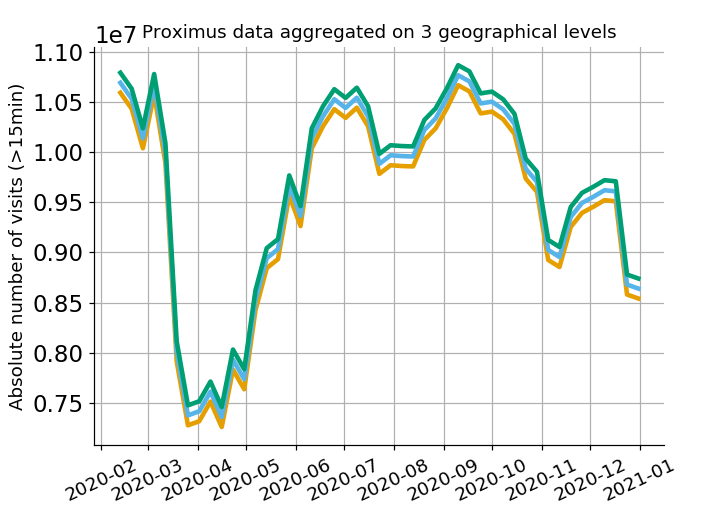

In [41]:
# All aggregations are identical: good sanity check.

year=2020
aggs=['mun', 'arr', 'prov']
weeks=np.arange(7,54)
offset=1e5 # offset for visualisation
fontsize=12


figure=plt.figure()
for idx, agg in enumerate(aggs):
    dates=[]
    total_mob=[]
    for week in weeks:
        date = week_to_date(week, day=4) # day=4 for middle of week
        dates.append(date)
        total_mob_weekly = load_avg_mobility(week, year=year, agg=agg).sum().sum()
        total_mob.append(total_mob_weekly + idx*offset)
    plt.plot(dates, total_mob)
    
plt.title('Proximus data aggregated on 3 geographical levels',fontsize=fontsize)
plt.ylabel('Absolute number of visits (>15min)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
figure.tight_layout()

<IPython.core.display.Javascript object>


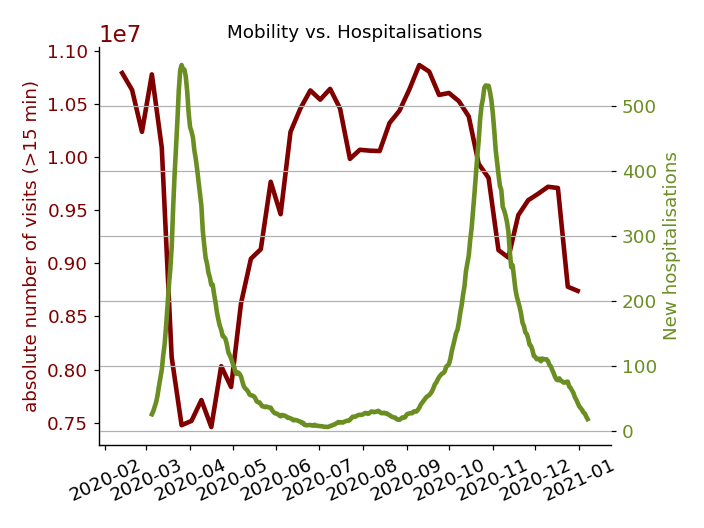

In [63]:
# Overlay total mobility over hospitalisation data

# Note: takes input from private data

fontsize=12

agg_type = 'prov'
data_file = '../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_' + agg_type + '.csv'

# Load and copy the data file
raw_data = pd.read_csv(data_file, sep=',', header=0,  parse_dates = ['DATE'])
raw_data.fillna(0, inplace=True)

# select and average data
hosp_data = raw_data[['DATE','hospitalised_IN']].groupby(['DATE']).sum()
hosp_data = moving_avg(hosp_data)
hosp_indices = hosp_data.index.values
hosp_values = hosp_data['hospitalised_IN'].values


fig, ax1 = plt.subplots()
ax1.grid(False)

color = 'maroon'
# ax1.set_xlabel('date')
ax1.set_ylabel('absolute number of visits (>15 min)', color=color, fontsize=fontsize)
ax1.plot(dates, total_mob, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'olivedrab'
ax2.set_ylabel('New hospitalisations', color=color, fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(hosp_indices, hosp_values, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=fontsize)

fig.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Mobility vs. Hospitalisations', fontsize=fontsize)
plt.show()



# figure=plt.figure()
# plt.plot(data.groupby(['DATE']).sum())
# figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
# # plt.xticks(rotation=30)
# figure.tight_layout()

# Animations

Note: this is additional and interesting for visualisation, not core science.

## Varying over destination NIS for fixed date

In [ ]:
########################
# Uncomment to execute #
########################

# # Add columns with 'traffic to' values
# to_NIS = mmprox_mun.columns

# municipalities_anim = municipalities.copy()

# # Prepare empty columns
# for nis in to_NIS:
#     municipalities_anim['Traffic to ' + nis] = 0
    
# # Add value to proper column
# for nis_from in municipalities_anim['NISCode'].values:
#     for nis_to in to_NIS:
#         municipalities_anim.loc[municipalities_anim['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_mun.loc[nis_from, nis_to]

In [ ]:
########################
# Uncomment to execute #
########################

# Plot connections

# from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
# from matplotlib import colors

# vmin=0
# vmax=np.max(np.max(mmprox_mun))
# dpi=200

# for nis in to_NIS:
#     # Make figure
#     fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
#     cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
#     ax.set_axis_off()
    
#     fig = municipalities_anim.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
#                                 legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

#     textbox = 'Traffic to NIS code ' + nis
#     plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
#     plt.close()

#     # (Create directory and) save figure
#     path = '../figures/maps/mun/mobility/'
#     chart = fig.get_figure()
#     chart.savefig(path+'mobility-to-NIS-' + nis + '.jpg' ,dpi=dpi, bbox_inches='tight')
#     print("saving NIS", nis)

## Varying over date for fixed destination NIS

### Straight from the data

In [64]:
# Load data for all available dates 

def get_date_from_file(filename):
    suffix_len = len(proximus_mobility_suffix())
    date_len = 8
    date = filename[-suffix_len-date_len:-suffix_len]
    return date
    
data_location = "../../data/raw/mobility/proximus/"

# ordered list of all available dates
dates_YYYYMMDD=[]
for file in os.listdir(data_location):
    if file.endswith(proximus_mobility_suffix()):
        date = get_date_from_file(file)
        dates_YYYYMMDD.append(date)

In [49]:
# Load all data in a big dictionary
# ## COMMENTED OUT FOR SAFETY ###

# mmprox = load_mobility_proximus(dates_YYYYMMDD, data_location)

Loaded dataframe for date 20210107.    


In [61]:
# Clean all data
# TAKES 4 seconds per date
### COMMENTED OUT FOR SAFETY ###

# agg='mun'
# mmprox_clean = dict({})
# for date in dates_YYYYMMDD:
#     mmprox_clean[date] = complete_data_clean(mmprox[date], agg=agg)
#     print(f"Total clean for date {date}.   ", end= '\r')
# print(f"Total clean for date {date}.")

Total clean for date 20210107.   


In [63]:
# Save this (locally) for future reference, because it takes a while to load/clean everything ...
# Also takes a while to save ...
### COMMENTED OUT FOR SAFETY ###

# save_location = #pick location
# save_prefix = 'çleaned-mobility-data_' + agg + '_'
# for date in dates_YYYYMMDD:
#     save_name = save_location + save_prefix + str(date)
#     mmprox[date].to_csv(save_name)
#     print(f"Saved file {save_prefix + str(date) + '.csv'}   ", end= '\r')
# print(f"Saved file {save_prefix + str(date) + '.csv'}")

Saved file çleaned-mobility-data_mun_20210107.   


In [69]:
# Sanity check: 

import datetime

dates_datetime = [datetime.datetime.strptime(date, '%Y%m%d') for date in dates_YYYYMMDD]
total_sum=[]
for date in dates_YYYYMMDD:
    total_sum.append(mmprox_clean[date].sum().sum())
    
figure=plt.figure()
plt.plot(dates_datetime, total_sum)
figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
figure.tight_layout()

Simply the 'overall' mobility is not very informative. We are more interested in actually seeing the difference in mobility play out over the days in a geographically intuitive way ...

In [213]:
# Geopandas animation

########################
# Uncomment to execute #
########################

from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
from matplotlib import colors

chosen_nis = '11002' # Antwerpen

# Add column with 'traffic to' values
municipalities_anim = municipalities.copy()
municipalities_anim['Traffic to ' + chosen_nis] = 0

# Choose limits of legend
vmin=0
vmax=0
for date in dates:
    vmax_tmp = np.max(np.max(mmprox_clean[date]))
    if vmax_tmp > vmax : vmax = vmax_tmp

dpi=200

In [245]:
# Create sequence of geopandas maps for the chosen NIS value. Takes >1 second per image.

########################
# Uncomment to execute #
########################

# Suppress showing the images
plt.ioff()

for idx, date in enumerate(dates):
    # Prepare shapefile
    for nis_from in municipalities_anim['NISCode'].values:
        traffic_to = mmprox_clean[date].loc[nis_from, chosen_nis]
        municipalities_anim.loc[municipalities_anim['NISCode']==nis_from,'Traffic to ' + chosen_nis] = traffic_to
    
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 800 pixels x 700 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    fig = municipalities_anim.plot(column='Traffic to ' + chosen_nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox1 = 'Traffic to NIS code ' + chosen_nis
    textbox2 = 'Date: ' + date
    plt.figtext(.15, .25, textbox1, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    plt.figtext(.15, .20, textbox2, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/mun/mobility/daily/'
    chart = fig.get_figure()
    savename = 'mobility-to-NIS-' + chosen_nis + '_' + date + '_' + str(idx) + '.jpg'
    chart.savefig(path+savename, dpi=dpi, bbox_inches='tight')
    print("saving " + savename, end='\r')
print("saving " + savename)
    
plt.ion()

saving mobility-to-NIS-11002_20210107_330.jpg


### With moving average

uses `mmprox_clean` defined in previous cells

In [70]:
# This is not really essential but might be interesting to do: moving average
# Take moving average values for every date

import datetime
def date_shift(date, shift=0):
    date_original = datetime.datetime.strptime(date, '%Y%m%d')
    date_shifted = date_original + datetime.timedelta(days=shift)
    date_shifted_str = date_shifted.strftime('%Y%m%d')
    return date_shifted_str

def moving_avg_mobility(mmprox_dict, date, window_size=7, verbose=True):
    # Lean towards the past
    shift_left = int((window_size - window_size%2)/2) # gives 3 for 7, and 4 for 8
    shift_right = int((window_size - (window_size+1)%2)/2) # gives 3 for 7, and 3 for 8
    date_range = range(-shift_left, shift_right+1)
    dates=[date_shift(date, shift=i) for i in date_range]
    
    # Take subset of dates: only dates that are available in mmprox_dict
    dates_available = set(dates).intersection(set(mmprox_dict.keys()))
    if dates_available == set():
        raise Exception(f"Cannot average over empty set around date {date}.")
    if len(dates_available) < 3:
        print(f"Warning: dataframe set around date {date} only contains one or two elements.")
    dates_available = sorted(list(dates_available))
    
    # Calculate moving average
    first=True
    for date in dates_available:
        if first:
            mmprox_avg = mmprox_dict[date]
            first=False
        if not first:
            mmprox_avg = mmprox_avg.add(mmprox_dict[date])
    effective_window_size = len(dates_available)
    mmprox_avg = mmprox_avg / effective_window_size
    if verbose:
        print(f"Calculated moving average over {effective_window_size} dates: {dates_available}.")
    return mmprox_avg

In [72]:
# Create dictionary with moving-average values
mmprox_moving_avg=dict({})
for date in dates_YYYYMMDD:
    mmprox_moving_avg[date] = moving_avg_mobility(mmprox_clean, date, verbose=False)
    print(f"Calculated moving average for date {date}.   ", end= '\r')
print(f"Calculated moving average for date {date}.")

In [73]:
mmprox_clean['20200218'].sum().sum()

In [74]:
# Sanity check: 

dates_datetime = [datetime.datetime.strptime(date, '%Y%m%d') for date in dates]
total_sum_avg=[]
for date in dates:
    total_sum_avg.append(mmprox_moving_avg[date].sum().sum())
    
figure=plt.figure()
plt.plot(dates_datetime, total_sum_avg, color='r', alpha=0.4)
plt.plot(dates_datetime, total_sum)
figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
figure.tight_layout()

In [125]:
date='20201221'
shift_left=3
shift_right=3
date_range = range(-shift_left, shift_right+1)
for i in date_range:
    date_shift(date)
# dates=[date_shift(date, shift=i) for i in date_range]

# Sketchbook

## Calculating baseline mobility

We want to know the mobility matrix for the average mobility in (at least) three different time frames:
1. Regular business day (perhaps on day per day basis?)
2. Regular weekend day (perhaps Saturday distinct from Sunday?)
3. Vacation day (ideally also on day-per-day basis)

To achieve these data, we use mobility matrices from before the first national lockdown (18 March. The available data comes from weeks 7 (10 February) to week 11 (i.e. 5 complete weeks)
1. 10-14 February, 17-21 February, 2-6 March, 9-13 March
2. 15-16 February, 22-23 February, 7-8 March, 14-15 March
3. 24 February to 1 March (spring break)

Note: it is quite possible that the final week before lockdown cannot be considered as a regular week.

### Visualising the baseline data

In [400]:
# First load the data and inspect the mobility for this date range
# Takes around ... minutes.

# Set to True to reload data
update=False

from datetime import date, datetime, timedelta
dates_prelockdown=[]
dates_prelockdown_datetime=[]

sdate = datetime(2020, 2, 10, 0, 0)   # start date
edate = datetime(2020, 3, 15, 0, 0)   # end date
delta = edate - sdate       # as timedelta

for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    dates_prelockdown_datetime.append(day)
    dates_prelockdown.append(date_to_YYYYMMDD(day))
    
# Load data for all these dates
if update:
    data_location = '../../data/raw/mobility/proximus/'
    mmprox_prelockdown, missing_dates = load_mobility_proximus(dates_prelockdown, data_location, return_missing=True)

# date array for xaxis (takes care of missing dates: needs same number of elements in array!)
dates_prelockdown_xaxis = dates_prelockdown_datetime.copy()
for d in missing_dates:
    dates_prelockdown_xaxis.remove(date_to_YYYYMMDD(d, inverse=True))

# Clean data for all dates at arrondissement level
if update:
    agg='arr'
    for d in mmprox_prelockdown:
        mmprox_prelockdown[d] = complete_data_clean(mmprox_prelockdown[d], agg=agg)
        print(f"cleaned data for date {d}", end='\r')
    print(f"cleaned data for date {d}")

    total_mobility_prelockdown=[]

    for d in mmprox_prelockdown:
        # Save array with available dates in datetime format
        date_prelockdown_datetime = date_to_YYYYMMDD(d, inverse=True)
        # Add total mobility to array
        total_mobility_tmp = mmprox_prelockdown[d].sum().sum()
        total_mobility_prelockdown.append(total_mobility_tmp)

### Calculating the baseline mobility per arrondissement

In [401]:
# Make arrays of relevant days
vacation_days=[]
business_days=[]
weekend_days=[]
vacation_dict=dict({})
business_dict=dict({})
weekend_dict=dict({})

vacation_sdate = datetime(2020, 2, 24, 0, 0)   # start date
for i in range(7):
    day = vacation_sdate + timedelta(days=i)
    day_YYYYMMDD = date_to_YYYYMMDD(day)
    vacation_days.append(day_YYYYMMDD)
    if day_YYYYMMDD in mmprox_prelockdown:
        vacation_dict[day_YYYYMMDD] = mmprox_prelockdown[day_YYYYMMDD]
    
for d in mmprox_prelockdown:
    if d not in vacation_days:
        d_datetime = date_to_YYYYMMDD(d, inverse=True)
        if d_datetime.isoweekday() in [6,7]:
            weekend_days.append(d)
            if d in mmprox_prelockdown:
                weekend_dict[d] = mmprox_prelockdown[d]
        else:
            business_days.append(d)
            if d in mmprox_prelockdown:
                business_dict[d] = mmprox_prelockdown[d]

In [501]:
# Calculate average matrices and average total sums
mmprox_baseline_vacation = average_mobility(vacation_dict)
mmprox_baseline_business = average_mobility(business_dict)
mmprox_baseline_weekend = average_mobility(weekend_dict)

vacation_baseline = mmprox_baseline_vacation.sum().sum()
business_baseline = mmprox_baseline_business.sum().sum()
weekend_baseline = mmprox_baseline_weekend.sum().sum()

11000          12000          13000          21000  \
mllp_postalcode                                                               
11000            534616.571429   20444.142857   15411.285714    7264.714286   
12000             27830.285714  159161.428571    8923.142857    5123.142857   
13000             21154.142857    8170.714286  221327.000000    2407.142857   
21000              5305.142857    2599.571429    1749.000000  637278.857143   
23000             10318.571429   11615.428571    3451.714286  101033.000000   
24000              9026.142857   11946.714286    8605.571429   15998.714286   
25000              2416.857143     926.428571     886.285714   38382.714286   
31000              2437.142857     718.714286     950.857143    1896.285714   
32000               435.428571     130.142857     238.857143     264.571429   
33000               870.285714     232.000000     416.142857     609.714286   
34000              2639.714286     786.000000    1145.142857    1988.428571   
35000              1380.142857     389.857143     498.571429    1210.571429   
36000               933.000000     305.142857     450.000000     648.571429   
37000              1021.571429     277.142857     491.857143     682.142857   
38000               558.142857     176.000000     171.857143     427.857143   
41000              2832.857143    1221.428571    1144.285714    9196.142857   
42000              3873.285714    4233.285714    1018.285714    3072.142857   
43000              1275.285714     329.571429     527.000000     626.714286   
44000              6992.285714    1952.571429    2408.857143    6721.428571   
45000              1337.714286     398.285714     495.000000    1565.428571   
46000             16099.857143    3781.142857    1275.857143    1390.571429   
51000               801.571429     302.857143     232.714286    5352.000000   
52000              1131.857143     451.857143     361.142857    5483.142857   
53000               807.142857     302.000000     242.285714    4326.428571   
55000               422.428571     185.428571     128.000000    4497.857143   
56000               280.857143     109.571429     102.428571    1516.857143   
57000               942.428571     269.857143     339.000000    3494.285714   
58000               358.000000     146.285714     139.000000    2088.714286   
61000               449.285714     143.714286     182.000000    1623.000000   
62000              1841.714286     509.714286     954.142857    6040.714286   
63000              1112.428571     354.857143     609.714286    2832.285714   
64000               429.857143     187.285714     264.714286    2011.857143   
71000              4576.142857    1764.571429    8596.000000    2952.142857   
72000              2514.000000     923.285714    4340.000000    1159.857143   
73000              2014.428571     774.571429    1517.142857    1304.142857   
81000               115.857143      47.000000      33.000000     559.571429   
82000               294.571429      92.428571     103.714286     582.857143   
83000               361.714286     100.142857     172.142857     968.714286   
84000               325.000000     101.714286      86.571429    1140.571429   
85000               164.285714      35.000000      37.714286     845.714286   
91000               700.714286     195.714286     195.285714    2433.285714   
92000              1150.285714     412.285714     415.000000    6857.714286   
93000               288.285714      67.000000      55.428571     800.428571   
Foreigner         84702.000000   11202.000000   32871.857143  162496.142857   

                         23000          24000          25000          31000  \
mllp_postalcode                                                               
11000             10828.142857    7778.714286    2524.428571    3220.571429   
12000             12837.571429   12274.285714    1398.285714    1179.857143   
13000              3761.000000   10189.000000    1035.000000    1345.57142

<IPython.core.display.Javascript object>


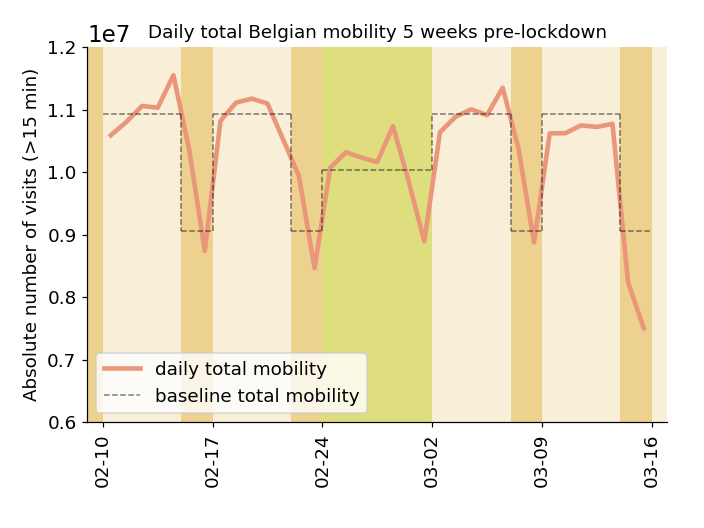

In [563]:
# Plotting environment
import matplotlib.dates as mdates
fontsize=12
color='darksalmon'
data_label='daily total mobility'
    
fig, ax1 = plt.subplots()
ax1.grid(False)

ax1.set_ylabel('Absolute number of visits (>15 min)', fontsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)
# ax1.set_xlabel('Date', fontsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)
myFmt = mdates.DateFormatter('%m-%d')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_xlim([dates_prelockdown_datetime[0]-timedelta(1), dates_prelockdown_datetime[-1]+timedelta(2)])
xticks_prelockdown = dates_prelockdown_datetime[0:-1:7] + [dates_prelockdown_datetime[-1]+timedelta(1)]
ax1.set_xticks(xticks_prelockdown)
ax1.set_ylim(.6e7, 1.2e7)

dates_prelockdown_xaxis_shifted = np.array(dates_prelockdown_xaxis)+timedelta(hours=12)
ax1.plot(dates_prelockdown_xaxis_shifted, total_mobility_prelockdown, label=data_label, color=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Daily total Belgian mobility 5 weeks pre-lockdown', fontsize=fontsize)
fig.autofmt_xdate(bottom=.2, rotation=90, ha='center', which=None) # Automatic x-tick fix!

# Add coloured bands
week_colour = 'wheat'
weekend_colour = 'goldenrod'
vacation_colour = 'y'
week_baseline_colour = 'k'
weekend_baseline_colour = 'k'
vacation_baseline_colour = 'k'
alpha=0.5
linewidth=1
baseline_alpha=0.5
label_baseline='baseline total mobility'

# Business days
plt.axvspan(sdate + timedelta(0), sdate + timedelta(5), facecolor=week_colour, alpha=alpha)
plt.plot((sdate + timedelta(0), sdate + timedelta(5)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(7), sdate + timedelta(12), facecolor=week_colour, alpha=alpha)
plt.plot((sdate + timedelta(7), sdate + timedelta(12)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(21), sdate + timedelta(26), facecolor=week_colour, alpha=alpha)
plt.plot((sdate + timedelta(21), sdate + timedelta(26)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(28), sdate + timedelta(33), facecolor=week_colour, alpha=alpha)
plt.plot((sdate + timedelta(28), sdate + timedelta(33)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Weekends
plt.axvspan(sdate + timedelta(5), sdate + timedelta(7), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate + timedelta(5), sdate + timedelta(7)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(12), sdate + timedelta(14), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate + timedelta(12), sdate + timedelta(14)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(26), sdate + timedelta(28), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate + timedelta(26), sdate + timedelta(28)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(33), sdate + timedelta(35), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate + timedelta(33), sdate + timedelta(35)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Vacation days
plt.axvspan(sdate + timedelta(14), sdate + timedelta(19), facecolor=vacation_colour, alpha=alpha)
plt.plot((sdate + timedelta(14), sdate + timedelta(19)), (vacation_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate + timedelta(19), sdate + timedelta(21), facecolor=vacation_colour, alpha=alpha)
plt.plot((sdate + timedelta(19), sdate + timedelta(21)), (vacation_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Inbetween dotted lines (aesthetical)
plt.plot((sdate + timedelta(5), sdate + timedelta(5)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha, label=label_baseline)
plt.plot((sdate + timedelta(7), sdate + timedelta(7)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(12), sdate + timedelta(12)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(14), sdate + timedelta(14)), (weekend_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(21), sdate + timedelta(21)), (vacation_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(26), sdate + timedelta(26)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(28), sdate + timedelta(28)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate + timedelta(33), sdate + timedelta(33)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Edges
plt.axvspan(sdate + timedelta(35), sdate + timedelta(36), facecolor=week_colour, alpha=alpha)
plt.axvspan(sdate + timedelta(-2), sdate + timedelta(0), facecolor=weekend_colour, alpha=alpha)

plt.legend(fontsize=fontsize)
plt.show()

**Problems**:

1. Days are clearly different (especially Saturday and Sunday). I need a reference stating which days are similar to which other days.
2. At a small scale (municipality) the data is surely to noisy to find a good baseline
3. When comparing to the baseline value, what to do when pandemic values go _over_ the baseline?
4. The final weekend doesn't really count (people were already holding back due to impending restrictions). Probably better to take this out.
5. Aesthetical: would be nice if the bands are translated 12 hours to the left, but the datetime objects don't easily support that.
6. I am still working with _all kinds_ of transportation. It would be interesting to filter out travel to the home patch, and only sum travel to other patches.
7. Explain very well in the preprint Appendix why it is necessary to take average mobilities and not just actual mobilities. Two reasons: (1) the Proximus data is also just an estimate, so averaging takes out the noise; (2) we want to be able to compare the actual mobility to the baseline mobility in order to estimate the contact behaviour, and comparing on a day-to-day basis definitely gives too much noise (perhaps demonstrate this?)
8. Fractional mobility _also_ goes down for home traffic. How is that?! Depends on the definition of home mobility, certainly.

**Solution**:
1. Don't compare _daily_ traffic because that will surely be too noisy. Instead, compare the average mobility in the particular time slot (business day, weekend day, vacation day) with the average in the same period and fill in this type of mobility.

### Comparing the baseline mobilty with the actual mobility during lockdown

Total _daily mobility_ and _total mobility averaged_ over the relevant time frame (business days, weekends, vacation days) is plotted for 5 weeks: week 12 to 16. Weeks 15 and 16 are Easter vacation weeks. So ...
1. Week 12-14: 16 March to 5 April
2. Week 15-16: 6 April to 19 April

In [456]:
# Again load and clean the data, now for different time period
# Takes about 2 minutes

# Set update to True to reload
update=False

from datetime import date, timedelta, datetime
dates_postlockdown=[]

sdate_postlockdown = datetime(2020, 3, 16, 0, 0)   # start date
edate_postlockdown = datetime(2020, 4, 19, 0, 0)   # end date
delta_postlockdown = edate_postlockdown - sdate_postlockdown    # as timedelta

for i in range(delta_postlockdown.days + 1):
    day = sdate_postlockdown + timedelta(days=i)
    dates_postlockdown.append(date_to_YYYYMMDD(day))
    
# Load data for all these dates
if update:
    data_location = '../../data/raw/mobility/proximus/'
    mmprox_postlockdown, missing_dates = load_mobility_proximus(dates_postlockdown, data_location, return_missing=True)

# date array for xaxis (takes care of missing dates: needs same number of elements in array!)
dates_postlockdown_xaxis = dates_postlockdown_datetime.copy()
for d in missing_dates:
    dates_postlockdown_xaxis.remove(date_to_YYYYMMDD(d, inverse=True))

# Clean data for all dates at arrondissement level
if update:
    agg='arr'
    for d in mmprox_postlockdown:
        mmprox_postlockdown[d] = complete_data_clean(mmprox_postlockdown[d], agg=agg)
        print(f"cleaned data for date {d}", end='\r')
    print(f"cleaned data for date {d}")

In [457]:
def is_weekend(day_YYYYMMDD):
    day_datetime = date_to_YYYYMMDD(day_YYYYMMDD, inverse=True)
    if day_datetime.isoweekday() in [6,7]:
        return True
    else:
        return False

# Not entirely elegant, but OK ...
def is_vacation(day_YYYYMMDD, sday, eday):
    vacation=[]
    now = date_to_YYYYMMDD(sday, inverse=True)
    then = date_to_YYYYMMDD(eday, inverse=True)
    while now <= then:
        vacation.append(date_to_YYYYMMDD(now))
        now += timedelta(1)
    if day_YYYYMMDD in vacation:
        return True
    else:
        return False

In [490]:
vacation_first='20200406'
vacation_last='20200419'

# There must be an easier way ...

d = dates_postlockdown_datetime[0]
mmprox_average_dict = dict({})
while d <= dates_postlockdown_datetime[-1]:
    d_string = date_to_YYYYMMDD(d)
    if is_vacation(d_string, vacation_first, vacation_last):
        mmprox_vacation = 0
        dates_vacation = []
        number_of_days = 0
        while is_vacation(d_string, vacation_first, vacation_last): # First vacation (copy block for every vacation)
            dates_vacation.append(d_string)
            if d_string in mmprox_postlockdown:
                mmprox_vacation += mmprox_postlockdown[d_string]
                number_of_days += 1
            d += timedelta(1) # UPDATE VALUE
            d_string = date_to_YYYYMMDD(d)
        if number_of_days == 0:
            raise Exception(f"No vacation data available between {vacation_first} and {vacation_last}.")
        mmprox_vacation_avg = mmprox_vacation / number_of_days
        for d_tmp in dates_vacation: # Update overall dictionary
            mmprox_average_dict[d_tmp] = mmprox_vacation_avg
    else:
        if is_weekend(d_string):
            mmprox_weekend = 0
            dates_weekend = []
            number_of_days = 0
            while is_weekend(d_string) and not is_vacation(d_string, vacation_first, vacation_last):
                dates_weekend.append(d_string)
                if d_string in mmprox_postlockdown:
                    mmprox_weekend += mmprox_postlockdown[d_string]
                    number_of_days += 1
                d += timedelta(1) # UPDATE VALUE
                d_string = date_to_YYYYMMDD(d)
            if number_of_days == 0:
                raise Exception(f"No weekend data available in weekend right before {d_string}.")
            mmprox_weekend_avg = mmprox_weekend / number_of_days
            for d_tmp in dates_weekend: # Update overall dictionary
                mmprox_average_dict[d_tmp] = mmprox_weekend_avg
        else:
            mmprox_business = 0
            dates_business = []
            number_of_days = 0
            while not is_weekend(d_string) and not is_vacation(d_string, vacation_first, vacation_last):
                dates_business.append(d_string)
                if d_string in mmprox_postlockdown:
                    mmprox_business += mmprox_postlockdown[d_string]
                    number_of_days += 1
                d += timedelta(1) # UPDATE VALUE
                d_string = date_to_YYYYMMDD(d)
            if number_of_days == 0:
                raise Exception(f"No business day data available in week right before {d_string}.")
            mmprox_business_avg = mmprox_business / number_of_days
            for d_tmp in dates_business: # Update overall dictionary. Insert value for EVERY date
                mmprox_average_dict[d_tmp] = mmprox_business_avg

In [495]:
# Save array with total mobility (from raw data), belonging to dates in dates_postlockdown_xaxis
total_mobility_postlockdown=[]

for d in mmprox_postlockdown:
    # Add total mobility to array
    total_mobility_tmp = mmprox_postlockdown[d].sum().sum()
    total_mobility_postlockdown.append(total_mobility_tmp)
    
# Save array with total mobility averaged over particular time slot (processed data)
total_mobility_average=[]

for d in mmprox_average_dict:
    total_mobility_tmp = mmprox_average_dict[d].sum().sum()
    total_mobility_average.append(total_mobility_tmp)

In [423]:
# Save values averaged over relevant time frame

# Initiate arrays of relevant values
averaged_values=[]
vacation_len = 14 # days
business_len = 5
weekend_len = 2

day_idx = 0
while day_idx < len(dates_postlockdown_xaxis):
    day_datetime = dates_postlockdown_xaxis[day_idx]
    day_YYYYMMDD = date_to_YYYYMMDD(day_datetime)
    # Three scenarios
    # Vacation
    if day_YYYYMMDD in easter_vac_days:
        averaged_value = np.mean(total_mobility_postlockdown[day_idx:day_idx+vacation_len])
        averaged_values = np.concatenate((averaged_values, [averaged_value]*vacation_len))
        day_idx += vacation_len
    else:
        # Weekend
        if day_datetime.isoweekday() in [6,7]:
            averaged_value = np.mean(total_mobility_postlockdown[day_idx:day_idx+weekend_len])
            averaged_values = np.concatenate((averaged_values, [averaged_value]*weekend_len))
            day_idx += weekend_len
        # Business day
        if day_datetime.isoweekday() in [1, 2, 3, 4, 5]:
            averaged_value = np.mean(total_mobility_postlockdown[day_idx:day_idx+business_len])
            averaged_values = np.concatenate((averaged_values, [averaged_value]*business_len))
            day_idx += business_len

# plt.plot(dates_postlockdown_datetime, averaged_values)
# plt.plot(dates_postlockdown_datetime, total_mobility_postlockdown, alpha=0.5)

<IPython.core.display.Javascript object>


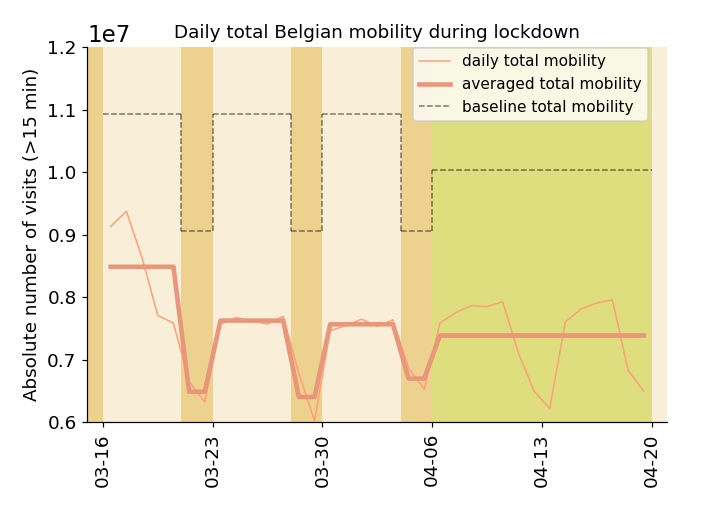

In [560]:
# Plotting environment
import matplotlib.dates as mdates
import datetime
fontsize=12
color_daily='lightsalmon'
alpha_daily=1
color_averaged='darksalmon'
data_label_daily='daily total mobility'
data_label_averaged='averaged total mobility'
    
fig, ax2 = plt.subplots()
ax2.grid(False)

ax2.set_ylabel('Absolute number of visits (>15 min)', fontsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)
# ax2.set_xlabel('Date', fontsize=fontsize)
ax2.tick_params(axis='x', labelsize=fontsize)
myFmt = mdates.DateFormatter('%m-%d')
ax2.xaxis.set_major_formatter(myFmt)
ax2.set_xlim([dates_postlockdown_datetime[0]-datetime.timedelta(1), dates_postlockdown_datetime[-1]+datetime.timedelta(2)])
xticks_postlockdown = dates_postlockdown_datetime[0:-1:7] + [dates_postlockdown_datetime[-1]+datetime.timedelta(1)]
ax2.set_xticks(xticks_postlockdown)
ax2.set_ylim(.6e7, 1.2e7)

dates_postlockdown_datetime_shifted = np.array(dates_postlockdown_datetime)+datetime.timedelta(hours=12)
ax2.plot(dates_postlockdown_datetime_shifted, total_mobility_postlockdown, label=data_label_daily, alpha=alpha_daily, linewidth=1,color=color_daily)
ax2.plot(dates_postlockdown_datetime_shifted, averaged_values, label=data_label_averaged, linewidth=3, color=color_averaged)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Daily total Belgian mobility during lockdown', fontsize=fontsize)
fig.autofmt_xdate(bottom=.2, rotation=90, ha='center', which=None) # Automatic x-tick fix!

# Add coloured bands
week_colour = 'wheat'
weekend_colour = 'goldenrod'
vacation_colour = 'y'
week_baseline_colour = 'k'
weekend_baseline_colour = 'k'
vacation_baseline_colour = 'k'
alpha=0.5
linewidth=1
baseline_alpha=0.5
label_baseline='baseline total mobility'

# Add coloured bands
week_colour = 'wheat'
weekend_colour = 'goldenrod'
vacation_colour = 'y'
week_baseline_colour = 'k'
weekend_baseline_colour = 'k'
vacation_baseline_colour = 'k'
alpha=0.5
linewidth=1
baseline_alpha=0.5
label_baseline='baseline total mobility'

# Business days
plt.axvspan(sdate_postlockdown + datetime.timedelta(0), sdate_postlockdown + datetime.timedelta(5), facecolor=week_colour, alpha=alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(0), sdate_postlockdown + datetime.timedelta(5)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(7), sdate_postlockdown + datetime.timedelta(12), facecolor=week_colour, alpha=alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(7), sdate_postlockdown + datetime.timedelta(12)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(14), sdate_postlockdown + datetime.timedelta(19), facecolor=week_colour, alpha=alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(14), sdate_postlockdown + datetime.timedelta(19)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(28), sdate_postlockdown + datetime.timedelta(33)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Weekends
plt.axvspan(sdate_postlockdown + datetime.timedelta(5), sdate_postlockdown + datetime.timedelta(7), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(5), sdate_postlockdown + datetime.timedelta(7)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(12), sdate_postlockdown + datetime.timedelta(14), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(12), sdate_postlockdown + datetime.timedelta(14)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(19), sdate_postlockdown + datetime.timedelta(21), facecolor=weekend_colour, alpha=alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(19), sdate_postlockdown + datetime.timedelta(21)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(26), sdate_postlockdown + datetime.timedelta(28)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(33), sdate_postlockdown + datetime.timedelta(35)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Vacation days
plt.axvspan(sdate_postlockdown + datetime.timedelta(21), sdate_postlockdown + datetime.timedelta(26), facecolor=vacation_colour, alpha=alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(26), sdate_postlockdown + datetime.timedelta(28), facecolor=vacation_colour, alpha=alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(28), sdate_postlockdown + datetime.timedelta(33), facecolor=vacation_colour, alpha=alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(33), sdate_postlockdown + datetime.timedelta(35), facecolor=vacation_colour, alpha=alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(21), sdate_postlockdown + datetime.timedelta(35)), (vacation_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Inbetween dotted lines (aesthetical)
plt.plot((sdate_postlockdown + datetime.timedelta(5), sdate_postlockdown + datetime.timedelta(5)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha, label=label_baseline)
plt.plot((sdate_postlockdown + datetime.timedelta(7), sdate_postlockdown + datetime.timedelta(7)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(12), sdate_postlockdown + datetime.timedelta(12)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(14), sdate_postlockdown + datetime.timedelta(14)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(19), sdate_postlockdown + datetime.timedelta(19)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.plot((sdate_postlockdown + datetime.timedelta(21), sdate_postlockdown + datetime.timedelta(21)), (weekend_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Edges
plt.axvspan(sdate_postlockdown + datetime.timedelta(35), sdate_postlockdown + datetime.timedelta(36), facecolor=week_colour, alpha=alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(-2), sdate_postlockdown + datetime.timedelta(0), facecolor=weekend_colour, alpha=alpha)

plt.legend(fontsize=fontsize-2, bbox_to_anchor=(.98, .9), loc='center right')

### Calculating $\pi^{gh}$ per time slot

In the plot above, the total mobility is shown. We are eventually interested not in the total mobility, but in the mobility between regions $g$ and $h$. Interested, in other words in a $G \times G$ matrix with values $\pi^{gh}$ that denote how traffic is _decreased_ compared to the baseline values, i.e. fractions of the values depicted above as resp. the darksalmon-coloured line and the black dashed line.

We need two things:
1. Baseline mobility matrix: $G \times G$ baseline values based on the pre-lockdown period, averaged over _all_ data in the particular type of time frame (business/week/vacation). `mmprox_baseline_*`
2. Actual mobility matrix: baseline values averaged over the _local_ time frame (i.e. just one weekend, or just one business day). `mmprox_average_dict`

In [534]:
# Define the ratio matrix \pi^{gh} for every date in a dictionary

vacation_first='20200406'
vacation_last='20200419'

pi_gh = dict({})
for d in dates_postlockdown:
    if is_vacation(chosen_date, vacation_first, vacation_last):
        pi_gh[d] = mmprox_average_dict[d] / mmprox_baseline_vacation
    elif is_weekend(chosen_date):
        pi_gh[d] = mmprox_average_dict[d] / mmprox_baseline_weekend
    else:
        pi_gh[d] = mmprox_average_dict[d] / mmprox_baseline_business

<IPython.core.display.Javascript object>


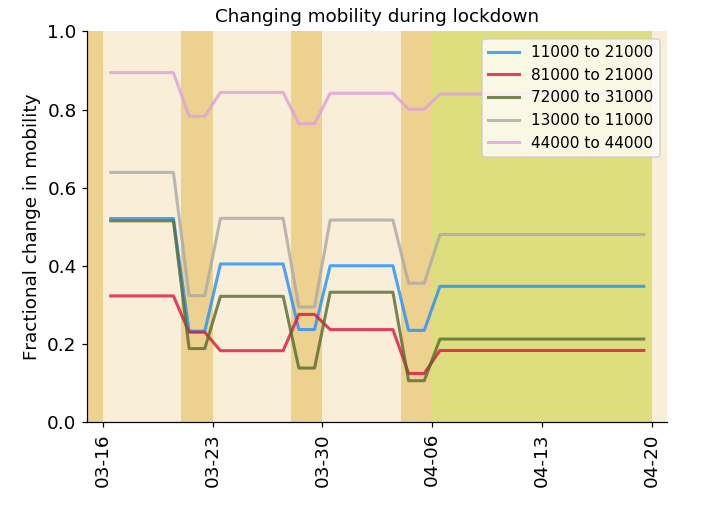

In [559]:
nis_combos = [('11000', '21000'), ('81000', '21000'), ('72000', '31000'), ('13000', '11000'), ('44000', '44000')]

# Plotting environment
import matplotlib.dates as mdates
import datetime
fontsize=12
color1='dodgerblue'
color2='crimson'
color3='darkolivegreen'
color4='darkgrey'
color5='plum'
colors=[color1, color2, color3, color4, color5]
label1=nis_combos[0][0] + ' to ' + nis_combos[0][1]
label2=nis_combos[1][0] + ' to ' + nis_combos[1][1]
label3=nis_combos[2][0] + ' to ' + nis_combos[2][1]
label4=nis_combos[3][0] + ' to ' + nis_combos[3][1]
label5=nis_combos[4][0] + ' to ' + nis_combos[4][1]
labels=[label1, label2, label3, label4, label5]
    
fig, ax3 = plt.subplots()
ax3.grid(False)

ax3.set_ylabel('Fractional change in mobility', fontsize=fontsize)
ax3.tick_params(axis='y', labelsize=fontsize)
# ax3.set_xlabel('Date', fontsize=fontsize)
ax3.tick_params(axis='x', labelsize=fontsize)
myFmt = mdates.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(myFmt)
ax3.set_xlim([dates_postlockdown_datetime[0]-datetime.timedelta(1), dates_postlockdown_datetime[-1]+datetime.timedelta(2)])
xticks_postlockdown = dates_postlockdown_datetime[0:-1:7] + [dates_postlockdown_datetime[-1]+datetime.timedelta(1)]
ax3.set_xticks(xticks_postlockdown)
ax3.set_ylim(0, 1)

dates_postlockdown_datetime_shifted = np.array(dates_postlockdown_datetime)+datetime.timedelta(hours=12)
for idx, nis_combo in enumerate(nis_combos):
    pi_values=[pi_gh[d].loc[nis_combo[0], nis_combo[1]] for d in dates_postlockdown]
    ax3.plot(dates_postlockdown_datetime_shifted, pi_values, label=labels[idx], color=colors[idx], linewidth=2, alpha=0.8)


# ax3.plot(dates_postlockdown_datetime_shifted, total_mobility_postlockdown, label=data_label_daily, alpha=alpha_daily, linewidth=1,color=color_daily)
# ax3.plot(dates_postlockdown_datetime_shifted, averaged_values, label=data_label_averaged, linewidth=3, color=color_averaged)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('Changing mobility during lockdown', fontsize=fontsize)
fig.autofmt_xdate(bottom=.2, rotation=90, ha='center', which=None) # Automatic x-tick fix!

# Add coloured bands
week_colour = 'wheat'
weekend_colour = 'goldenrod'
vacation_colour = 'y'
week_baseline_colour = 'k'
weekend_baseline_colour = 'k'
vacation_baseline_colour = 'k'
alpha=0.5
linewidth=1
baseline_alpha=0.5
label_baseline='baseline total mobility'

# Add coloured bands
week_colour = 'wheat'
weekend_colour = 'goldenrod'
vacation_colour = 'y'
week_baseline_colour = 'k'
weekend_baseline_colour = 'k'
vacation_baseline_colour = 'k'
alpha=0.5
linewidth=1
baseline_alpha=0.5
label_baseline='baseline total mobility'

# Business days
plt.axvspan(sdate_postlockdown + datetime.timedelta(0), sdate_postlockdown + datetime.timedelta(5), facecolor=week_colour, alpha=alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(0), sdate_postlockdown + datetime.timedelta(5)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(7), sdate_postlockdown + datetime.timedelta(12), facecolor=week_colour, alpha=alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(7), sdate_postlockdown + datetime.timedelta(12)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(14), sdate_postlockdown + datetime.timedelta(19), facecolor=week_colour, alpha=alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(14), sdate_postlockdown + datetime.timedelta(19)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(28), sdate_postlockdown + datetime.timedelta(33)), (business_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Weekends
plt.axvspan(sdate_postlockdown + datetime.timedelta(5), sdate_postlockdown + datetime.timedelta(7), facecolor=weekend_colour, alpha=alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(5), sdate_postlockdown + datetime.timedelta(7)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(12), sdate_postlockdown + datetime.timedelta(14), facecolor=weekend_colour, alpha=alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(12), sdate_postlockdown + datetime.timedelta(14)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(19), sdate_postlockdown + datetime.timedelta(21), facecolor=weekend_colour, alpha=alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(19), sdate_postlockdown + datetime.timedelta(21)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(26), sdate_postlockdown + datetime.timedelta(28)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(33), sdate_postlockdown + datetime.timedelta(35)), (weekend_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Vacation days
plt.axvspan(sdate_postlockdown + datetime.timedelta(21), sdate_postlockdown + datetime.timedelta(26), facecolor=vacation_colour, alpha=alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(26), sdate_postlockdown + datetime.timedelta(28), facecolor=vacation_colour, alpha=alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(28), sdate_postlockdown + datetime.timedelta(33), facecolor=vacation_colour, alpha=alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(33), sdate_postlockdown + datetime.timedelta(35), facecolor=vacation_colour, alpha=alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(21), sdate_postlockdown + datetime.timedelta(35)), (vacation_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Inbetween dotted lines (aesthetical)
# plt.plot((sdate_postlockdown + datetime.timedelta(5), sdate_postlockdown + datetime.timedelta(5)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha, label=label_baseline)
# plt.plot((sdate_postlockdown + datetime.timedelta(7), sdate_postlockdown + datetime.timedelta(7)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(12), sdate_postlockdown + datetime.timedelta(12)), (business_baseline, weekend_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(14), sdate_postlockdown + datetime.timedelta(14)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(19), sdate_postlockdown + datetime.timedelta(19)), (weekend_baseline, business_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)
# plt.plot((sdate_postlockdown + datetime.timedelta(21), sdate_postlockdown + datetime.timedelta(21)), (weekend_baseline, vacation_baseline), 'k--', linewidth=linewidth, alpha=baseline_alpha)

# Edges
plt.axvspan(sdate_postlockdown + datetime.timedelta(35), sdate_postlockdown + datetime.timedelta(36), facecolor=week_colour, alpha=alpha)
plt.axvspan(sdate_postlockdown + datetime.timedelta(-2), sdate_postlockdown + datetime.timedelta(0), facecolor=weekend_colour, alpha=alpha)

plt.legend(fontsize=fontsize-2, loc='upper right')

In [553]:
pi_gh['20200318']

11000     12000     13000     21000     23000     24000  \
mllp_postalcode                                                               
11000            0.880595  0.677906  0.696152  0.521369  0.633479  0.652833   
12000            0.592908  0.966195  0.723445  0.466354  0.702236  0.672984   
13000            0.639383  0.726130  0.927829  0.617911  0.745919  0.664344   
21000            0.688049  0.680651  0.841395  0.848740  0.710926  0.697401   
23000            0.669027  0.718389  0.666799  0.547047  0.977828  0.691472   
24000            0.676014  0.721805  0.724577  0.462212  0.680286  0.906332   
25000            0.609221  0.656500  0.641554  0.430444  0.715557  0.693019   
31000            0.738816  0.693739  0.706941  0.539687  0.755289  0.634983   
32000            0.842848  0.573216  0.566866  0.513283  0.781207  0.630409   
33000            0.572226  0.617241  0.522417  0.500890  0.547326  0.482397   
34000            0.718260  0.686514  0.779117  0.582168  0.648320  0.526105   
35000            0.640803  0.734115  0.793066  0.539745  0.677132  0.671114   
36000            0.749411  0.753090  0.722222  0.677181  0.738609  0.511653   
37000            0.788589  0.970619  0.620912  0.696628  0.799380  0.657556   
38000            0.663629  0.662500  0.749460  0.684808  0.788424  0.574731   
41000            0.783167  0.722760  0.706467  0.480397  0.829608  0.683175   
42000            0.631970  0.772969  0.829040  0.450044  0.762607  0.703036   
43000            0.752929  0.629909  0.538520  0.524322  0.553682  0.464227   
44000            0.619340  0.697747  0.617305  0.428183  0.688410  0.583554   
45000            0.707625  0.798924  0.600404  0.614784  0.784384  0.510198   
46000            0.641633  0.711002  0.783944  0.603493  0.718165  0.743609   
51000            0.589841  0.753491  0.902394  0.578924  0.807801  0.603649   
52000            0.617039  0.767942  0.582041  0.633141  0.810772  0.698424   
53000            0.644991  0.641060  0.555542  0.622037  0.733136  0.704789   
55000            0.562462  0.632049  0.592187  0.511221  0.773915  0.778323   
56000            0.700000  0.797653  0.505718  0.700264  0.603610  0.534220   
57000            0.762710  0.874537  0.710324  0.625478  0.686446  0.583905   
58000            0.714525  0.724609  0.415827  0.538609  0.880565  0.774457   
61000            0.547091  0.654076  0.704396  0.634134  0.626283  0.615496   
62000            0.581198  0.690583  0.680611  0.552021  0.577944  0.622594   
63000            0.770027  0.778905  0.682943  0.608554  0.538945  0.598701   
64000            0.582519  0.635393  0.534916  0.623504  0.634929  0.677127   
71000            0.762476  0.756784  0.697185  0.612775  0.676668  0.685113   
72000            0.772395  0.751447  0.743272  0.672324  0.785882  0.718412   
73000            0.739565  0.637514  0.903936  0.643181  0.734964  0.723663   
81000            0.298644  0.106383  0.406061  0.323462  0.333606  0.749142   
82000            0.436566  0.523648  0.665289  0.420000  0.400407  0.398567   
83000            0.775197  0.639087  0.640166  0.550627  0.603922  0.558356   
84000            0.382154  0.556461  0.487459  0.509744  0.495716  0.584981   
85000            0.465043  0.325714  0.593939  0.318311  0.284618  0.342746   
91000            0.553435  0.875766  0.561229  0.648670  0.603365  0.683867   
92000            0.615325  0.737838  0.575422  0.476427  0.704266  0.722429   
93000            0.641031  1.405970  0.736082  0.818062  0.715460  0.792562   
Foreigner        0.707235  0.761382  0.825320  0.535337  0.597102  0.712698   

                    25000     31000     32000     33000  ...     73000  \
mllp_postalcode                                          ...             
11000            0.611465  0.619828  0.548757  0.520116  ...  0.622649   
12000            0.741336  0.641095  0.603953  0.520492  ...  0.503886   
13000            0.725217  0.522603  0.793737  0.637571  ...  0.740452   
21000          

## Visualisation population per region

In [73]:
# Visualisation in geopandas
import geopandas as gp

shp_dir = "../../data/raw/GIS/shapefiles/BE/"

# Load different geographical aggregations
country = gp.read_file(shp_dir + "AD_6_Country.shp")
regions = gp.read_file(shp_dir + "AD_5_Region.shp")
provinces = gp.read_file(shp_dir + "AD_4_Province.shp")
arrondissements = gp.read_file(shp_dir + "AD_3_District.shp")
municipalities = gp.read_file(shp_dir + "AD_2_Municipality.shp")

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Create population per aggregation
population = dict({})
pop_loc = '../../data/interim/demographic/'
for agg in ['mun', 'arr', 'prov']:
    filename = pop_loc + 'initN_' + agg + '.csv'
    population[agg] = pd.read_csv(filename, index_col='NIS')[['total']]

In [74]:
arrondissements

ModifDate NISCode                                    tgid     Shape_Leng  \
0   2007-01-05   81000  {3E0FC3C6-1C73-48A2-83D1-7DC3A7AA8514}  138306.528302   
1   2007-01-05   82000  {EE733AA7-7FC2-4E69-888B-DF7ECFB64C35}  274752.161091   
2   2007-01-05   83000  {A6C31231-3E61-43CE-84E2-1438698DC257}  215795.867725   
3   2007-01-05   84000  {897E2BFE-980D-496E-881E-2ED9ABE005F5}  277555.661420   
4   2007-01-05   85000  {EDA0B812-D16F-4395-80B2-0189F6AF09F5}  206847.516841   
5   2007-01-05   91000  {2E974C14-FD3B-407F-884D-479E8F93E9CD}  372501.807316   
6   2007-01-05   92000  {51EBBE59-3B18-4D17-BC43-89B4365D9EE0}  251656.364154   
7   2007-01-05   93000  {A89A0808-863F-4357-B492-15A0BED55A66}  195937.951463   
8   2007-01-05   21000  {1AC6671D-002E-4412-B042-71527AA159D9}   72160.956955   
9   2007-01-05   11000  {0876A7BC-F0C1-4719-816A-44AC9D669ABF}  184480.414202   
10  2007-01-05   12000  {B5C24900-F47D-4AAF-ACE1-AC85309CBBA1}  175315.071813   
11  2007-01-05   13000  {5CFCE10D-05BA-46A9-8938-1974ABC35831}  289512.782387   
12  2007-01-05   71000  {22B003A6-2FF3-4EAB-A0FD-81C7C4527275}  277504.716069   
13  2007-01-05   72000  {9DD01BCB-BA00-4BD7-BF94-4C4DEB13048A}  168154.048679   
14  2007-01-05   73000  {CDA45C2C-917B-4535-B77F-CFF9DADCE7E2}  253896.388131   
15  2007-01-05   42000  {63D18A56-943B-400F-B7CA-3164F84B026B}  127485.906430   
16  2007-01-05   43000  {6B40A359-55C9-4E42-8CCE-10B593C83F7C}  120940.133397   
17  2007-01-05   45000  {A216DF62-378B-497B-8D25-410D114AAEC2}  152588.558000   
18  2007-01-05   23000  {593C104E-21A1-4C2B-9186-D5CB272782B7}  345556.115345   
19  2007-01-05   31000  {67723CFC-4345-47C4-AD31-51A9618C2DFA}  154269.203371   
20  2007-01-05   33000  {E3AD4F29-49B5-45FA-BB57-EEC5F2330E94}  178818.811009   
21  2007-01-05   35000  {CCFD2DB8-6ED5-46E9-8969-F667646DAAFD}  121561.924224   
22  2007-01-05   37000  {700947E7-ECD1-4AC2-8CE1-623871AA9192}  112485.187248   
23  2007-01-05   38000  {66533360-9D05-4F9F-BF3F-1418BBD259AE}  106184.268798   
24  2007-01-05   25000  {A00252BF-65D8-4EC7-96AF-828C7BEB06D2}  285854.641445   
25  2007-01-05   51000  {FD48E675-A314-453E-9126-55BF80A234E3}  237330.049010   
26  2007-01-05   52000  {18AE017F-1D41-44F8-AAB9-2D25CE0CFFBC}  137753.570998   
27  2007-01-05   53000  {E246E410-0929-4BC6-9511-6C74DD999050}  184416.902197   
28  2007-01-05   55000  {851F1243-C506-4C3F-964C-AD19917891A8}  131026.850269   
29  2007-01-05   56000  {F422F79E-88D7-4AB4-80D8-177B6F033D55}  274943.096406   
30  2007-01-05   57000  {C78DB25B-D78A-4B62-B0D9-029129BB847A}  263849.438127   
31  2007-01-05   61000  {CC9169BC-87BB-4B47-B4E4-146D218F30F0}  233935.521181   
32  2007-01-05   62000  {6006EA5A-D3F8-4838-9F1A-986466768A81}  225049.460546   
33  2007-01-05   63000  {5E66A84C-F4E5-4BA7-A3ED-C151C2834201}  421105.526587   
34  2007-01-05   64000  {6BCFF83F-78A4-43B7-A03A-8FDC2906086F}  174061.079997   
35  2007-01-05   41000  {42A3A2DC-1BCA-43CA-BFDD-CFE07CA757FC}  174893.452887   
36  2007-01-05   44000  {F50F5912-3D4D-4850-8C19-9E2DD6D7D7D6}  230299.286762   
37  2007-01-05   46000  {1C282C97-B1CC-4CC2-B417-6535733FD9AF}  135388.217386   
38  2007-01-05   24000  {A711E699-B2EF-444C-95A2-6FD4C55D713C}  296663.156236   
39  2007-01-05   32000  {FC8DA19D-1FB5-4E6A-BE00-1032A96209D1}  119108.582484   
40  2007-01-05   34000  {D3A720CC-385C-49AE-97AA-95094FACED34}  123909.317747   
41  2007-01-05   36000  {19A29C9A-D5FE-497A-9CEC-5B3D95348002}  110232.423007   
42  2018-12-19   58000  {A9BF3018-718F-4DC2-AA34-BDD88DDFF545}  104301.571774   

      Shape_Area               NameDut              NameFre   NameGer  \
0   3.188733e+08                  None                Arlon      None   
1   1.046626e+09                  None             Bastogne      None   
2   9.580514e+08                  None    Marche-en-Famenne      None   
3   1.358428e+09                  None         NeufchÃ¢teau      None   
4   7.772711e+08                  None               Virton      None   
5 

In [79]:
agg = 'mun'
for nis in population[agg].index:
    municipalities.loc[municipalities['NISCode'] == str(nis),'Population'] = int(population[agg].loc[nis, 'total'])
municipalities.head()

ModifDate  City  LanguageSt NISCode  DistrictCa  ProvinceCa  RegionCapi  \
0  2007-01-05     1           2   83034           1           0           0   
1  2007-01-05     1           1   23027           0           0           0   
2  2007-01-05     2           2   91103           0           0           0   
3  2007-01-05     1           2   91034           1           0           0   
4  2007-01-05     2           2   82037           0           0           0   

   CountryCap                                    tgid    Shape_Leng  \
0           0  {D0109DA3-34B8-46C0-92B8-BE65085732FB}  85650.096718   
1           0  {2E6FAFC1-84DF-472E-AA01-3499B29786C5}  45798.276630   
2           0  {26279847-D2CA-49E1-9EAE-0D8595F62FA7}  56990.073560   
3           0  {CD6CED5D-6CD9-4446-B643-B8CDAABAC8BA}  71326.001927   
4           0  {92E40A08-FC1A-44D5-94E3-D4D494FFB7C9}  76994.149941   

     Shape_Area NameDut            NameFre NameGer  \
0  1.220723e+08    None  Marche-en-Famenne    None   
1  4.498213e+07   Halle               None    None   
2  6.565876e+07    None             Onhaye    None   
3  1.000560e+08    None             Dinant    None   
4  1.653600e+08    None              Gouvy    None   

                                            geometry  Population  
0  POLYGON Z ((726984.424 600113.847 0.000, 72699...     17591.0  
1  POLYGON Z ((643229.384 658679.116 0.000, 64323...     40182.0  
2  POLYGON Z ((679740.122 601677.244 0.000, 67975...      3230.0  
3  POLYGON Z ((692802.454 600840.203 0.000, 69279...     13374.0  
4  POLYGON Z ((768030.137 598110.413 0.000, 76801...      5397.0

<IPython.core.display.Javascript object>


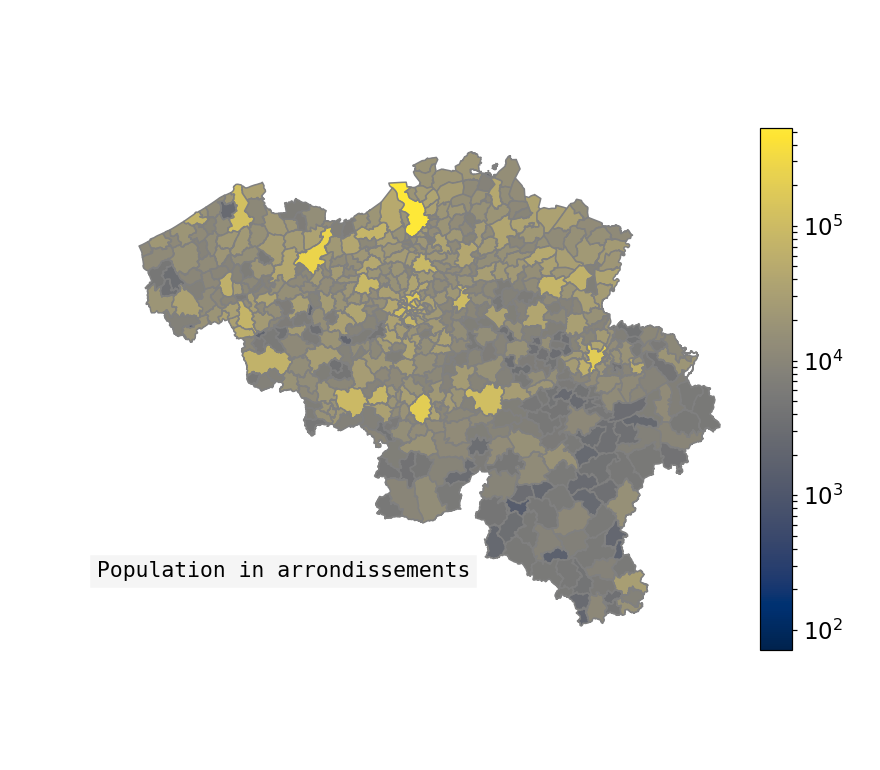

In [80]:
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
from matplotlib import colors

# Make figure
fig, ax = plt.subplots(figsize = (8,7)) # 800 pixels x 700 pixels
cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
ax.set_axis_off()
cmap='cividis'

vmin = min(municipalities['Population'])
vmax = max(municipalities['Population'])

fig = municipalities.plot(column='Population', ax=ax, cmap=cmap,
                            legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=100, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

textbox = 'Population in arrondissements'
plt.figtext(.11, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
# plt.close()

# (Create directory and) save figure
path = '../figures/maps/provinces/time_series_tests/'
chart = fig.get_figure()
# chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

## Explore other ways of analysing mobility data

We want to eventually have a mobility matrix $P$ with elements $P^{gh}$ that show the fraction of the population living in $g$ that are basically spending most of their day in region $h$. With the StatBel data this was rather easily achieved, because a person in region $g$ was simply registered as working in region $h$.

Example: if there are 1000 people in region 1, and 600 of these work in region 1, 300 in region 2 and 100 in region 3, this works out as simple fractions $P^{11} = 0.6, P^{12}=0.3, P^{13}=0.1$. Because of the fact that a person can only go to *one* place, the sum $\sum_{h=1}^G P^{gh}$ will always be unity.

The situation is not so easy for the Proximus data, because of the fact that ...
1. People that don't move all day are not registered at all
2. People can visit multiple places


This means that the total number of visits is not conserved, as it is dependent on the movement of the people. This calls for a different approach that is more complex but certainly also more informative - and an approach that we luckily have data for! Because the total *time* people have to spend certainly *is* conserved.

For every postal code, the number of users are registered (`imisinpostalcode`). PC 2000 (Antwerp) on 16 February 2020, for example, has 16084 registered users (that is to say: 16084 users have PC 2000 as their most likely living place). That means they have a total of $16084 \times 24 \times 60 \times 60 = 1389657600$ seconds to spend that day. Only $1209790773$ of these are registered, which means that $179866827$ seconds have gone unregistered. These seconds are distributed over two classes:
1. Inhabitants of PC 2000 who travel too fast (no connection over 15 minutes can be established)
2. Inhabitants of PC 2000 who have not been connected to a different transmission tower all day (**it works like that for visits, but does it also work like that for estimated staytime? Check this with Gerdy**)

As it is impossible to track the first class, we may *underestimate* the overall mobility by assuming that all missing seconds go into the second class. Total time spent in in PC 2000 is therefore the `est_staytime` added to calculated missing seconds. In general the `est_staytime` is much larger than the missing seconds; in this case the missing time only constitutes 16.4 percent of the total time spent in PC 2000.

Note that this choice may be altered. We may assume for example that it *only* consists of people that are travelling too fast, and therefore only undergo $N_{c,\text{transport}}$ contact.

In [18]:
import pandas as pd
datafile_name = "../../data/raw/mobility/proximus/outputPROXIMUS122747corona20200216AZUREREF001.csv"
raw_mob = pd.read_csv(datafile_name, sep=';', decimal=',', dtype={'mllp_postalcode' : str,
                                                                                     'postalcode' : str,
                                                                                     'imsisinpostalcode' : int,
                                                                                     'habitatants' : int,
                                                                                     'nrofimsi' : int,
                                                                                     'visitors' : int,
                                                                                     'est_staytime' : int,
                                                                                     'total_est_staytime' : int,
                                                                                     'est_staytime_perc' : float})
raw_mob2000 = raw_mob[raw_mob['mllp_postalcode']=='2000']
raw_mob2000[raw_mob2000['postalcode']=='2000']

mllp_postalcode postalcode  imsisinpostalcode  habitants  nrofimsi  \
50479            2000       2000              16084    62398.0     15018   

       visitors  est_staytime  total_est_staytime  est_staytime_perc  
50479     55266     913765475          1209790773           75.53087

In [21]:
# Note: the total_est_staytime also includes the times that are masked due to GDPR protocol

raw_mob2000.loc[raw_mob2000['nrofimsi']>=0, 'est_staytime'].sum()

1149114460

In [30]:
# The total percentage of time spent does not add up to 100, due to masked data.

raw_mob2000[raw_mob2000['nrofimsi']>=0]['est_staytime_perc'].sum()

94.98456315199999

**Translating time data to a mobility matrix**

Next we want to use these data to define the mobility matrix $P$, consisting of elements $P^{gh} \leq 1$ that denote the fraction of time spent. Neither the model nor the data can fully take into account that some people visit multiple places every day, nor is this really necessary, as we are working with a metapopulation model anyway. The mobility matrix is therefore calculated as a matrix of fractions calculated from the time spent from place $g$ at a certain place $h$, divided by the total time available to all inhabitants of place $g$.

We must also consider that
1. People typically sleep at home, give or take 8 hours a night. We may assume that in general people are not contageous at night for all practicle purposes. Yet, these 8 hours are counted as seconds spent in the home patch. To get a better picture of how much time people are socially active in their home patch, we choose to take out the equivalent of 8 hours out of time spent in the home patch.
2. Many people disconnect their phone at night (by turning off their phone or enabling flight mode). When they reconnect, this is counted as a visit to the home patch. We may generally presume that people turn off their phone before midnight and turn it back on in the morning, so the 'new visit' is counted every morning. This doesn't really matter, because in this approach we are concerned with the total time spent, not the absolute visit count, and whether or not this time is counted as "time in the home patch" or as "missing time" (**not sure which it is, perhaps ask this?**), they end up being counted in fraction $P^{gg}$ anyway.
3. How do we handle -1 values?
    - The total time is saved, luckily, but if `nrofimsi` is -1, so are `visitors`, `est_staytime` and `est_staytime_perc`. We know how much time is spent in total, so one way to go about would be to distribute this time equally over all destination postal codes. An obvious problem there is that this is certainly not realistic, as it overestimates visits far away, and underestimates visits closeby. This would be an important flaw in the entire spatial approach. **Hopefully we can get our hands on data at arrondissement level, such that this problem is circumvented**
    - For a number of postal codes, also `imsisinpostalcode` is GDPR-protected. We may circumvent this problem by estimating the population from the total estimated staytime, combined with the average fraction between total staytime and actual time in PCs that *do* have `imsisinpostalcode` data. Again, this is an issue and a source of uncertainty that is ideally omitted when we have **arrondissement-level data**.
4. Importantly: this percentage is already quoted in the raw mobility data (as `est_staytime_perc`). *But* the definition of this quantity may be too simplistic (`est_staytime`/`total_est_staytime` $\times 100\%$). Still, it is probably of interest to inspect this quantity as well.

Mathematically, if $T^g$ is the number of people registered in the PC, and $t^{gh}$ the time spent in $h \neq g$, we can define the mobility matrix:

$$
P^{gh} = \frac{t^{gh}}{T^g \times 16 \times 60 \times 60}
$$

Except when $g = h$, then

$$
P^{gg} = \frac{(t^{gg} + \Delta t - T^g \times 8 \times 60 \times 60)}{T^g \times 16 \times 60 \times 60}
$$

where $\Delta t$ are the 'missing seconds'. It should be verified that $\sum_{h=1}^G P^{gh}$ sums up to unity, which is the case because

$$
\sum_{h=1}^G t^{gh} = T^g \times 24 \times 60 \times 60 - \Delta t
$$

Below are the steps to get from the raw data to the mobility matrix $P$.

**Problems**
1. Some postalcodes have -1 users: this can be fixed by comparing the `total_est_staytime` with the `mllp_postalcode` for data that *are* available, and taking the median ratio to estimate the `mllp_postalcode` of GDPR-protected data
3. Some postalcodes are not mentioned because they have no visitors at all. These are added at the very end with a `est_staytime` of zero. As we aggregate on arrondissement level, the effect of this lack of data is negligible.

In [332]:
# Load the datafile
datum='20210127'
location='../../data/raw/mobility/proximus/'
unprocessed_data = load_datafile_proximus(datum, location)
unprocessed_data

mllp_postalcode postalcode  imsisinpostalcode  habitants  nrofimsi  \
0                 1000       1000            14993.0    52832.0   14250.0   
1                 1000       1020            14993.0    52832.0     373.0   
2                 1000       1030            14993.0    52832.0     606.0   
3                 1000       1040            14993.0    52832.0     949.0   
4                 1000       1050            14993.0    52832.0    1312.0   
...                ...        ...                ...        ...       ...   
291501       Foreigner       9988           381744.0        NaN     220.0   
291502       Foreigner       9990           381744.0        NaN     564.0   
291503       Foreigner       9991           381744.0        NaN     305.0   
291504       Foreigner       9992           381744.0        NaN     117.0   
291505       Foreigner     ABROAD           381744.0        NaN  208088.0   

        visitors  est_staytime  total_est_staytime  est_staytime_perc  
0        46591.0  9.039503e+08        1.128257e+09          80.119170  
1         1220.0  4.305160e+06        1.128257e+09           0.381576  
2         1981.0  7.739741e+06        1.128257e+09           0.685991  
3         3103.0  1.388068e+07        1.128257e+09           1.230276  
4         4290.0  1.691382e+07        1.128257e+09           1.499110  
...          ...           ...                 ...                ...  
291501     560.0  4.618521e+06        1.821687e+10           0.025353  
291502    1485.0  9.343111e+06        1.821687e+10           0.051288  
291503     798.0  4.450126e+06        1.821687e+10           0.024429  
291504     262.0  3.428636e+06        1.821687e+10           0.018821  
291505  407227.0  2.936130e+09        1.821687e+10          16.117647  

[291506 rows x 9 columns]

In [333]:
# First we estimate the number of people that live in a certain PC if this information is not provided
# because of GDPR protection. Luckily total_est_staytime *is* always provided.

clients_per_pc = pd.pivot_table(unprocessed_data, index='mllp_postalcode', values=['imsisinpostalcode', 'total_est_staytime'], aggfunc='first')

clients_per_pc_available = clients_per_pc.loc[clients_per_pc['imsisinpostalcode']>0]
clients_per_pc_available['people_per_staytime'] = clients_per_pc_available['imsisinpostalcode'] \
    / clients_per_pc_available['total_est_staytime']

# calculate median people per staytime
median_people_per_staytime = clients_per_pc_available['people_per_staytime'].median()
print("Median number of people per staytime:", median_people_per_staytime)

# Change negative values with estimated number of people living somewhere
clients_per_pc.loc[clients_per_pc['imsisinpostalcode']<0, 'imsisinpostalcode'] \
    = clients_per_pc.loc[clients_per_pc['imsisinpostalcode']<0, 'total_est_staytime'] * median_people_per_staytime

# now there are values <=30, giving us an estimate of a value that was previously unknown due to GDPR protection
clients_per_pc.loc[clients_per_pc['imsisinpostalcode']<=30]

Median number of people per staytime: 1.2982857899531083e-05


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


imsisinpostalcode  total_est_staytime
mllp_postalcode                                       
1473                     20.897481           1609621.0
3051                      4.382247            337541.0
3052                     11.028808            849490.0
3473                     10.734240            826801.0
3501                      4.144310            319214.0
3721                      7.555517            581961.0
3792                      2.181704            168045.0
4252                      1.088405             83834.0
4263                      0.959368             73895.0
4672                      1.574613            121284.0
5024                      9.283600            715066.0
5334                      3.704048            285303.0
5352                     25.478988           1962510.0
5354                     14.225395           1095706.0
5504                      1.000758             77083.0
5564                      5.333150            410784.0
5573                      1.612081            124170.0
5574                     11.298150            870236.0
6223                      9.453312            728138.0
6441                     13.362490           1029241.0
6463                      1.764422            135904.0
6533                     10.712935            825160.0
6542                      4.891707            376782.0
6692                      7.659886            590000.0
6721                     14.885197           1146527.0
6742                     11.504617            886139.0
6781                      3.565677            274645.0
6782                      3.480354            268073.0
6834                      8.578436            660751.0
6836                      2.129734            164042.0
6922                     15.681475           1207860.0
7611                      4.762839            366856.0
7621                      9.940208            765641.0
7743                      9.776728            753049.0
7781                      4.997414            384924.0
7863                     10.350674            797257.0
7906                      1.814432            139756.0
7943                     21.421131           1649955.0
9551                      4.775420            367825.0

In [334]:
# We use the number of people to estimate the number of seconds people are at home without having been registered
# These seconds (denoted \Delta t in the theory) may be added to the time spent for people 'travelling' to their own home

# Available time in seconds
clients_per_pc['total_available_time'] = clients_per_pc['imsisinpostalcode'] * 24 * 60 * 60
clients_per_pc['missing_seconds'] = clients_per_pc['total_available_time'] - clients_per_pc['total_est_staytime']

missing_seconds_per_pc = clients_per_pc.copy()
missing_seconds_per_pc
# missing_seconds_per_pc[missing_seconds_per_pc['missing_seconds']<0] # This should be empty, which it is

imsisinpostalcode  total_est_staytime  total_available_time  \
mllp_postalcode                                                                
1000                       14993.0        1.128257e+09          1.295395e+09   
1020                       14024.0        1.063961e+09          1.211674e+09   
1030                       28934.0        2.178686e+09          2.499898e+09   
1040                       22926.0        1.726721e+09          1.980806e+09   
1050                       35097.0        2.628077e+09          3.032381e+09   
...                            ...                 ...                   ...   
9988                         788.0        6.138766e+07          6.808320e+07   
9990                        4953.0        3.871779e+08          4.279392e+08   
9991                        2767.0        2.153407e+08          2.390688e+08   
9992                         287.0        2.130139e+07          2.479680e+07   
Foreigner                 381744.0        1.821687e+10          3.298268e+10   

                 missing_seconds  
mllp_postalcode                   
1000                1.671380e+08  
1020                1.477128e+08  
1030                3.212113e+08  
1040                2.540856e+08  
1050                4.043036e+08  
...                          ...  
9988                6.695535e+06  
9990                4.076134e+07  
9991                2.372807e+07  
9992                3.495406e+06  
Foreigner           1.476582e+10  

[1126 rows x 4 columns]

That is **the first type of information** that we needed. We'll save it for when we have a grid of staytimes,
to either add it to the rest of the `est_staytime`$^{gg}$, or to keep it aside (because this behaviour may imply different social interaction). **Note**, by the way, that the `missing_seconds` for foreigners is an order of magnitude larger than the `total_est_staytime`, denoting that most foreigners only spend a fraction of their day connected over 15 minutes to a particular tower of the Belgian telecom grid (e.g. truckers that only briefly stop along the way but are counted as individual users).

Next we want to find an acceptable filler for the -1 values in the `est_staytime` slots that are protected by GDPR.

*pseudocode*
- calculate difference between `total_est_staytime` and the sum of all `est_staytime`s for a particular PC
- For every `mllp_postalcode`, calculate the number of times -1 occurs
- Divide the time difference by this number
- For this `mllp_postalcode`, change the -1 value by the newly calculated number
- Go to next `mllp_postalcode`

When all that is done, the first 'clean' has happened. Then we may proceed to aggregate 

In [340]:
# Simple "raw" grid of "people from g spend x time in h". 0 values means none are registered, -1 means it is protected
staytime_matrix = pd.pivot_table(unprocessed_data, index='mllp_postalcode', columns='postalcode', values='est_staytime').fillna(value=0)

# Total non-GDPR protected time per PC (should be smaller than total_est_time)
est_staytime_noGDPR = staytime_matrix[staytime_matrix>0].fillna(value=0).sum(axis=1)

# Number of times -1 occurs per PC (i.e. number of postal codes for which data is protected)
# Note: this is a lot! The maximum is 700 (which is more than half of all 1148 PCs)
small_number_freq = staytime_matrix[staytime_matrix==-1].fillna(value=0).sum(axis=1).astype(int).abs()

# Average time difference per GDPR-protected postalcode, between total registered time and the sum of the individually registered times
est_staytime_GDPR = (missing_seconds_per_pc['total_est_staytime'] - est_staytime_noGDPR) / small_number_freq

# For most mllp_postalcode, this is not a big value (order of couple hours)
# For foreigners it is of the order of a few days. Reasoning:
#   1. The registered total_est_staytime is large
#   2. The est_staytimes that are registered are low (just over threshold)
# Again this is due to the nature of foreigners visiting Belgium: they travel around much (truckers) and typically don't
# Stay at a particular place for a long time. It would be nice to have an actual source for this rather than a reasoning
est_staytime_GDPR 

mllp_postalcode
1000          63221.349073
1020          53622.230216
1030          71988.330946
1040          76797.535484
1050          88932.543885
                 ...      
9988          46109.561905
9990          47991.168350
9991          38209.456140
9992          52205.828125
Foreigner    279281.846939
Length: 1126, dtype: float64

In [364]:
# Now we add the first and the second "extra time" to the proper place such that we can aggregate in the next stage

mmprox_staytime = pd.pivot_table(unprocessed_data, index='mllp_postalcode', columns='postalcode', \
                                 values='est_staytime').fillna(value=0)
for pc in mmprox_staytime.index:
    if pc != 'Foreigner':
        mmprox_staytime.loc[pc, pc] += missing_seconds_per_pc.loc[pc, 'missing_seconds']
    else:
        mmprox_staytime.loc[pc, 'ABROAD'] += missing_seconds_per_pc.loc[pc, 'missing_seconds']

# ... And add change the -1 values to the estimated values. (Again: this is arguably not
# the best way to go about here, evenly distributing it everywhere ...)

for pc in mmprox_staytime.index:
    mmprox_staytime.loc[pc, mmprox_staytime.loc[pc]<0] = est_staytime_GDPR[pc]
    
mmprox_staytime.head()

postalcode               1000         1020          1030          1040  \
mllp_postalcode                                                          
1000             1.071088e+09    4305160.0  7.739741e+06  1.388068e+07   
1020             1.419117e+07  979405457.0  1.107502e+07  5.630825e+06   
1030             2.782033e+07   11496506.0  2.083224e+09  3.439011e+07   
1040             1.967036e+07    3062275.0  3.162237e+07  1.653443e+09   
1050             3.492866e+07    3436482.0  1.159546e+07  6.232204e+07   

postalcode               1050        1060        1070        1080       1081  \
mllp_postalcode                                                                
1000             1.691382e+07  27825344.0  18735826.0  21182361.0  1187681.0   
1020             6.477743e+06   2731249.0   9533940.0   7905203.0  1156584.0   
1030             2.043460e+07   6233719.0   9671119.0   7822761.0  1349087.0   
1040             6.395068e+07   5696658.0   5936898.0   4079135.0   757054.0   
1050             2.564538e+09  22209525.0  11118688.0   5054392.0  1066980.0   

postalcode            1082  ...          9970  9971  9980  9981  9982  9988  \
mllp_postalcode             ...                                               
1000             1127368.0  ...      0.000000   0.0   0.0   0.0   0.0   0.0   
1020             2690473.0  ...      0.000000   0.0   0.0   0.0   0.0   0.0   
1030             2387922.0  ...      0.000000   0.0   0.0   0.0   0.0   0.0   
1040             1119099.0  ...      0.000000   0.0   0.0   0.0   0.0   0.0   
1050             1327043.0  ...  88932.543885   0.0   0.0   0.0   0.0   0.0   

postalcode               9990          9991  9992      ABROAD  
mllp_postalcode                                                
1000                 0.000000      0.000000   0.0   6987016.0  
1020             53622.230216  53622.230216   0.0   4357490.0  
1030             71988.330946      0.000000   0.0  10408673.0  
1040                 0.000000      0.000000   0.0  12538043.0  
1050             88932.543885      0.000000   0.0  26944174.0  

[5 rows x 1134 columns]

In [370]:
# Next we may continue with the already defined clean (add additional postal codes) and aggregation
mmprox_staytime_mun = mm_aggregate(fill_missing_pc(mmprox_staytime), agg='mun')
mmprox_staytime_mun.head()

postalcode              11001         11002         11004         11005  \
mllp_postalcode                                                           
11001            3.494773e+08  2.124983e+07  8.243443e+04  5.912289e+06   
11002            1.418272e+07  9.662644e+09  5.738566e+06  5.430597e+06   
11004            5.398848e+05  1.233025e+07  3.154541e+08  9.057391e+04   
11005            6.900662e+06  1.272836e+07  1.159871e+05  3.917076e+08   
11007            5.148048e+04  2.395327e+07  1.449894e+06  5.148048e+04   

postalcode              11007         11008         11009         11013  \
mllp_postalcode                                                           
11001            4.121721e+04  4.121721e+04  4.121721e+04  2.117607e+06   
11002            1.589751e+07  4.174778e+07  6.958789e+06  4.222349e+07   
11004            1.732551e+06  9.057391e+04  9.057391e+04  1.791637e+06   
11005            5.799355e+04  5.799355e+04  5.799355e+04  8.724910e+05   
11007            1.805276e+08  5.148048e+04  5.148048e+04  4.286230e+05   

postalcode               11016         11018  ...          92141  \
mllp_postalcode                               ...                  
11001             41217.214286  1.033245e+06  ...       0.000000   
11002            770540.571341  8.381995e+06  ...  236638.170586   
11004             46005.149573  9.057391e+04  ...       0.000000   
11005                 0.000000  1.109016e+06  ...       0.000000   
11007             51480.483871  5.148048e+04  ...       0.000000   

postalcode               92142  93010          93014         93018  \
mllp_postalcode                                                      
11001             41217.214286    0.0       0.000000      0.000000   
11002            512262.237296    0.0  222966.752868  51750.117978   
11004                 0.000000    0.0       0.000000      0.000000   
11005             57993.547619    0.0       0.000000      0.000000   
11007             51480.483871    0.0       0.000000      0.000000   

postalcode               93022          93056         93088          93090  \
mllp_postalcode                                                              
11001                 0.000000       0.000000      0.000000       0.000000   
11002            254385.755109  100857.191695      0.000000  178206.015954   
11004                 0.000000       0.000000      0.000000       0.000000   
11005                 0.000000   57993.547619  57993.547619       0.000000   
11007                 0.000000       0.000000      0.000000       0.000000   

postalcode             ABROAD  
mllp_postalcode                
11001            4.121721e+04  
11002            3.258473e+07  
11004            8.159918e+05  
11005            1.284571e+06  
11007            5.148048e+04  

[5 rows x 582 columns]

In [377]:
mmprox_staytime_mun.div(mmprox_staytime_mun.sum(axis=1), axis=0)

postalcode          11001     11002     11004     11005     11007     11008  \
mllp_postalcode                                                               
11001            0.844442  0.051346  0.000199  0.014286  0.000100  0.000100   
11002            0.001351  0.920765  0.000547  0.000517  0.001515  0.003978   
11004            0.001411  0.032237  0.824732  0.000237  0.004530  0.000237   
11005            0.014567  0.026868  0.000245  0.826856  0.000122  0.000122   
11007            0.000221  0.102680  0.006215  0.000221  0.773867  0.000221   
...                   ...       ...       ...       ...       ...       ...   
93022            0.000000  0.000359  0.000000  0.000000  0.000000  0.000000   
93056            0.000000  0.000144  0.000000  0.000000  0.000000  0.000000   
93088            0.000000  0.000212  0.000071  0.000000  0.000000  0.000000   
93090            0.000000  0.000775  0.000000  0.000000  0.000000  0.000000   
Foreigner        0.000358  0.030485  0.000166  0.000475  0.000164  0.001108   

postalcode          11009     11013     11016     11018  ...     92141  \
mllp_postalcode                                          ...             
11001            0.000100  0.005117  0.000100  0.002497  ...  0.000000   
11002            0.000663  0.004024  0.000073  0.000799  ...  0.000023   
11004            0.000237  0.004684  0.000120  0.000237  ...  0.000000   
11005            0.000122  0.001842  0.000000  0.002341  ...  0.000000   
11007            0.000221  0.001837  0.000221  0.000221  ...  0.000000   
...                   ...       ...       ...       ...  ...       ...   
93022            0.000000  0.000000  0.000000  0.000000  ...  0.000344   
93056            0.000000  0.000000  0.000000  0.000000  ...  0.000144   
93088            0.000000  0.000000  0.000000  0.000000  ...  0.000281   
93090            0.000000  0.000000  0.000000  0.000000  ...  0.000387   
Foreigner        0.000895  0.000615  0.001282  0.000233  ...  0.000149   

postalcode          92142     93010     93014     93018     93022     93056  \
mllp_postalcode                                                               
11001            0.000100  0.000000  0.000000  0.000000  0.000000  0.000000   
11002            0.000049  0.000000  0.000021  0.000005  0.000024  0.000010   
11004            0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11005            0.000122  0.000000  0.000000  0.000000  0.000000  0.000122   
11007            0.000221  0.000000  0.000000  0.000000  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
93022            0.000450  0.000225  0.001899  0.000893  0.839104  0.010882   
93056            0.000287  0.003707  0.026068  0.016627  0.011593  0.839493   
93088            0.000351  0.003534  0.002714  0.000141  0.012550  0.010911   
93090            0.000581  0.000194  0.048522  0.005140  0.003313  0.017502   
Foreigner        0.000661  0.000048  0.000655  0.000061  0.000157  0.000162   

postalcode          93088     93090    ABROAD  
mllp_postalcode                                
11001            0.000000  0.000000  0.000100  
11002            0.000000  0.000017  0.003105  
11004            0.000000  0.000000  0.002133  
11005            0.000122  0.000000  0.002712  
11007            0.000000  0.000000  0.000221  
...                   ...       ...       ...  
93022            0.017972  0.000225  0.000225  
93056            0.010766  0.005762  0.003771  
93088            0.830042  0.000141  0.002466  
93090            0.000387  0.844508  0.006572  
Foreigner        0.000252  0.000123  0.536704  

[582 rows x 582 columns]

In [ ]:
def load_mobility_timefractions(dates, data_location, complete=False, verbose=True, return_missing=False):
    """
    Load Proximus mobility data (number of visitors or visitor time) corresponding to the requested dates
    
    Input
    -----
    dates: str or list of str
        Single date in YYYYMMDD form or list of these (output of make_date_list function): requested date(s)
    data_location: str
        Name of directory (relative or absolute) that contains all Proximus data files
    complete: boolean
        If True, this function raises an exception when 'dates' contains a date that does not correspond to a data file.
    verbose: boolean
        If True, print statement every time data for a date is loaded.
    return_missing: boolean
        If True, return array of missing dates in form YYYYMMDD as second return. False by default.
    
    Returns
    -------
    mmprox_dict: dict of pandas DataFrames
        Dictionary with YYYYMMDD dates as keys and pandas DataFrames with fractions of total time spent.
    """
    # Check dates type and change to single-element list if needed
    single_date = False
    if isinstance(dates,str):
        dates = [dates]
        single_date = True
    
    missing = check_missing_dates(dates, data_location)
    load_dates = set(dates).difference(missing)
    dates_left = len(load_dates)
    if dates_left == 0:
        raise Exception("None of the requested dates correspond to a Proximus mobility file.")
    if missing != set():
        print(f"Warning: some or all of the requested dates do not correspond to Proximus data. Dates: {sorted(missing)}")
        if complete:
            raise Exception("Some requested data is not found amongst the Proximus files. Set 'complete' parameter to 'False' and rerun if you wish to proceed with an incomplete data set (not using all requested data).")
        print(f"... proceeding with {dates_left} dates.")

    # Initiate dict for remaining dates
    mmprox_dict=dict({})
    load_dates = sorted(list(load_dates))
    for date in load_dates:
        datafile = load_datafile_proximus(date, data_location)
        mmprox_temp = datafile[['mllp_postalcode', 'postalcode', values]]
        mmprox_temp = mmprox_temp.pivot_table(values=values,
                                              index='mllp_postalcode',
                                              columns='postalcode')
        mmprox_temp = mmprox_temp.fillna(value=0)
        if values == 'total_est_staytime':
            mmprox_dict[date] = mmprox_temp.convert_dtypes().abs()
        else:
            mmprox_dict[date] = mmprox_temp.convert_dtypes()
        if verbose==True:
            print(f"Loaded dataframe for date {date}.    ", end='\r')
    print(f"Loaded dataframe for date {date}.")
    
    if not return_missing:
        return mmprox_dict
    else:
        return mmprox_dict, sorted(missing)

In [49]:
# This shows all places where `imsisinpostalcode` is <30
raw_mob_low_mllp= pd.pivot_table(raw_mob, index='mllp_postalcode', values='imsisinpostalcode', aggfunc='first')
raw_mob_low_mllp[raw_mob_low_mllp['imsisinpostalcode']<=30]

imsisinpostalcode
mllp_postalcode                   
1473                            -1
3051                            -1
3052                            -1
3473                            -1
3501                            -1
3721                            -1
3792                            -1
4252                            -1
4263                            -1
4672                            -1
5024                            -1
5334                            -1
5352                            -1
5354                            -1
5504                            -1
5564                            -1
5573                            -1
5574                            -1
6223                            -1
6441                            -1
6463                            -1
6533                            -1
6542                            -1
6692                            -1
6721                            -1
6742                            -1
6781                            -1
6782                            -1
6834                            -1
6836                            -1
6922                            -1
7611                            -1
7621                            -1
7743                            -1
7781                            -1
7863                            -1
7906                            -1
7943                            -1
9551                            -1

In [77]:
# Here are entries with negative total_est_staytime (buggy entries)
raw_mob_neg_staytime = pd.pivot_table(raw_mob, index='mllp_postalcode', values='total_est_staytime')
raw_mob_neg_staytime[raw_mob_neg_staytime['total_est_staytime']<0]

total_est_staytime
mllp_postalcode                    
1030                     2116281040
1050                     1666890116
1070                     1844333656
1180                     1782237825
4000                     2081928297
9000                     1485889850